# Calculate metrics using climpred

---

Now that all of our model and observational data is ready for analysis, we can run this notebook and calculate various metrics using climpred across all models and seasons and compare how they do. It is recommended that you use `dask` to run this notebook as we are looking at geospatial data and making maps. You can start up a `dask` cluster by running the notebook `cluster.ipynb` and copying the Scheduler tcp number into this notebook.

In [2]:
import cftime
import numpy as np
import pandas as pd
import xarray as xr
xr.set_options(keep_attrs=True)
import climpred
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
from cartopy.util import add_cyclic_point
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import geopandas as gpd
import seaborn as sns
import shapefile as shp
from shapely.geometry import Polygon, MultiPolygon
import intake
import os.path
from tqdm import tqdm
import dask.array as da
import matplotlib.pyplot as plt
# import ultraplot as uplt
from matplotlib.ticker import FixedLocator
import matplotlib.path as mplPath
import xskillscore as xs
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

from dask.distributed import Client
import dask.config
dask.config.set({"array.slicing.split_large_chunks": False})

In [3]:
def shift_geometry(geom):
    if geom.is_empty:
        return geom
    if isinstance(geom, Polygon):
        new_coords = [(x+360 if x < 0 else x, y) for x, y in geom.exterior.coords]
        return Polygon(new_coords)
    elif isinstance(geom, MultiPolygon):
        new_polys = []
        for poly in geom.geoms:
            new_coords = [(x+360 if x < 0 else x, y) for x, y in poly.exterior.coords]
            new_polys.append(Polygon(new_coords))
        return MultiPolygon(new_polys)
    else:
        return geom

- Make sure you have copied the correct tcp here from the `cluster.ipynb` notebook

In [4]:
# client = Client("tcp://128.117.208.180:44419")

In [4]:
import dask
dask.config.set({'logging.distributed': 'error'})

from dask_jobqueue import PBSCluster

# For Casper
cluster = PBSCluster(
    queue="casper",
    walltime="02:00:00",
    account="P93300042",
    memory="8GB",
    resource_spec="select=1:ncpus=1:mem=4GB",
    # resource_spec="select=1:ncpus=1:mem=8GB",
    cores=1,
    processes=1,
)

from dask.distributed import Client

# Connect client to the remote dask workers
client = Client(cluster)
print(client)

cluster.scale(8)

client.wait_for_workers(8)


<Client: 'tcp://128.117.208.173:36757' processes=0 threads=0, memory=0 B>


In [5]:
savefig = "no" #yes or no
plotdir = ""

## Here is where you choose your variable, metric and start/end time.

In [49]:
variable = "t2m" #can be t2m, tp, gh_500
metric = "acc" #can be rps, rmse, acc, rpss
state = "soilm" #can be NAO, PNA, ENSO, MJO or just leave it blank
#reg = ['US_NE', 'US_Rockies', 'US_NW', 'US_Ohio', 'US_South', 'US_SE', 'US_SW','US_MW', 'US_West']
reg = ['US_NE','US_Rockies', 'US_NW', 'US_Ohio', 'US_South','US_SE','US_SW','US_MW', 'US_West']
reg2 = ["US_Northeast","US_NorthernRockies", "US_Northwest","US_OhioValley","US_South","US_Southeast","US_Southwest","US_UpperMidwest","US_West"]
ld = [1, 15, 31]
weeks = ["wk12","wk34","wk56"]

predict = "hindcast" #can be perfect or hindcast
# predict = "perfect" #can be perfect or hindcast

data = "anom"
lead = "biweekly" #biweekly or daily
area = "geospatial"
start = "1999-01-01"
end = "2020-12-31"

season = "JJA" # JJA, DJF, MAM, ann

# models = ["CESM2_climoLND","CESM2_orig"]
models = ["CESM2_climoATM"] #can be ECMWF, NCEP, ECCC, CESM2, CESM1 and WACCM
domain = "namerica" #can be global or namerica

In [50]:
# Here we are just setting options for the different metrics and mapping.
if metric == "acc":
    comp="e2o"; dim="init"; ens="ensmean" #options for metrics
    cmap="YlOrRd" #options for maps
    if variable=="t2m":
        vmin=-1.0; vmax=1.0
    elif variable=="tp":
        vmin=-0.7; vmax=0.7
elif metric=="rmse":
    comp="e2o"; dim="init"; ens="ensmean" #options for metrics
    cmap="viridis"; vmin=0.0; vmax=5.0 #options for maps
elif metric=="rps":
    comp="m2o"; dim=["init","member"]; ens="" #options for metrics
    cmap="viridis"; vmin=0.0; vmax=1.0 #options for maps
elif metric=="rpss":
    comp="m2o"; dim=["init","member"]; ens="" #options for metrics
    cmap="RdBu_r"; vmin=-0.8; vmax=0.8 #options for maps

## Now we read in and load the data into `dask`

We are using the intake catalog to find the data and load it up. Make sure you have the file `ASP_data_catalog.yml` in your local directory. Or you can find it here: `/glade/campaign/mmm/c3we/jaye/S2S_zarr/`

We have an `if` statement here telling us to load in category_edge files, only if our metric of choice is `rps`

In [51]:
cat = intake.open_catalog('/glade/campaign/mmm/c3we/jaye/S2S_zarr/ASP_data_catalog.yml')

In [32]:
# cat["CESM2_climoATM"]

In [52]:
hinds = {}
for m in models:
    hinds[m] = cat[m](data=data, lead=lead, dim=area).to_dask().astype('float32')
    if domain == "namerica":
        hinds[m] = hinds[m].sel(lat=slice(15.0, 75.0),lon=slice(190.0, 305.0))
verif = cat['OBS_SUBX'](data=data, lead=lead, dim=area).to_dask().astype('float32')
if domain == "namerica":
    verif = verif.sel(lat=slice(15.0, 75.0),lon=slice(190.0, 305.0))

In [35]:
cat['OBS_SUBX']

OBS_SUBX:
  args:
    chunks: auto
    urlpath: /glade/campaign/mmm/c3we/jaye/S2S_zarr/OBS_SUBX.raw.daily.geospatial.zarr
    use_cftime: true
  description: Observations to verify forecasts with. Most variables are from NOAA
    CPC, but geopotential height gh_500 and psl is from ERA.
  driver: intake_xarray.xzarr.ZarrSource
  metadata:
    catalog_dir: /glade/campaign/mmm/c3we/jaye/S2S_zarr/
    comment: gh_500 and psl from ERA
    sources:
    - http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.temperature/.daily/
    - http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.UNIFIED_PRCP/.GAUGE_BASED/.GLOBAL/.v1p0/.extREALTIME/.rain/
    - add-ERA-link


- All of the model data is now loaded into a dictionary so that we can have them all together for comparison purposes.

In [53]:
# is seasonal data available for all models and rechunk
for h in hinds:
    print(hinds[h].init.dt.season.to_index().unique(), 'freq =',hinds[h].init.to_index().freq) # freq would show weekly but calendar conversion breaks this
    hinds[h] = hinds[h].chunk({"member": "auto", "init": -1, "lead": "auto", "lat": 45, "lon": 60}).persist()
    hinds[h] = hinds[h].sel(init=slice(start,end))
    hinds[h] = hinds[h].where(-88.6<hinds[h].lat)
    hinds[h] = hinds[h].where(88.6>hinds[h].lat)
verif = verif.sel(time=slice(start,str(pd.to_datetime(end)+pd.DateOffset(days=46))))
if data=="raw" and variable=="t2m":
    verif = verif.chunk({"time": -1, "lat": 45, "lon": 60})+273.15
else:
    verif = verif.chunk({"time": -1, "lat": 45, "lon": 60})

Index(['DJF', 'MAM', 'JJA', 'SON'], dtype='object', name='init') freq = None


In [54]:
lmask = np.isnan(verif.t2m[0,:,:]).drop(["time"]) # making a landmask from the CPC data

In [55]:
if state=="soilm":
    soilm = xr.open_dataset("catDS_SMterciles_NOAAregions_quant-aft-regavg.nc").sel(init=slice(start,end))
    # soilm = xr.open_dataset("catDS_SMterciles_NOAAregions_terc-aft-regavg.nc").sel(init=slice(start,end))
    #soilm = xr.open_dataset("/glade/work/jaye/climpred/data/catDS_SMterciles_NOAAregions.nc").sel(init=slice(start,end))
    mask_neu = soilm["soilTercileCategory"].sel(region=reg) == "neutral"; neu = soilm.sel(region=reg).where(mask_neu, drop=True)
    #mask_mix = soilm["soilTercileCategory"].sel(region=reg) == "mixed";   mix = soilm.sel(region=reg).where(mask_mix, drop=True)
    mask_dry = soilm["soilTercileCategory"].sel(region=reg) == "dry";     dry = soilm.sel(region=reg).where(mask_dry, drop=True)
    mask_wet = soilm["soilTercileCategory"].sel(region=reg) == "wet";     wet = soilm.sel(region=reg).where(mask_wet, drop=True)
    neu["init"] = [cftime.DatetimeProlepticGregorian(pd.DatetimeIndex([d]).year[0], \
                                                     pd.DatetimeIndex([d]).month[0], \
                                                     pd.DatetimeIndex([d]).day[0]) for d in neu.init.values]
    #mix["init"] = [cftime.DatetimeProlepticGregorian(pd.DatetimeIndex([d]).year[0], \
    #                                                 pd.DatetimeIndex([d]).month[0], \
    #                                                 pd.DatetimeIndex([d]).day[0]) for d in mix.init.values]
    dry["init"] = [cftime.DatetimeProlepticGregorian(pd.DatetimeIndex([d]).year[0], \
                                                     pd.DatetimeIndex([d]).month[0], \
                                                     pd.DatetimeIndex([d]).day[0]) for d in dry.init.values]
    wet["init"] = [cftime.DatetimeProlepticGregorian(pd.DatetimeIndex([d]).year[0], \
                                                     pd.DatetimeIndex([d]).month[0], \
                                                     pd.DatetimeIndex([d]).day[0]) for d in wet.init.values]

In [56]:
regs_neu = {}; regs_mix = {}; regs_dry = {}; regs_wet = {}
for r in reg:
    print(r)
    regs_neu[r] = neu.sel(region=r).dropna(dim="init")
    #regs_mix[r] = mix.sel(region=r).dropna(dim="init")
    regs_dry[r] = dry.sel(region=r).dropna(dim="init")
    regs_wet[r] = wet.sel(region=r).dropna(dim="init")

US_NE
US_Rockies
US_NW
US_Ohio
US_South
US_SE
US_SW
US_MW
US_West


## Create a Hindcast Ensemble in climpred for each of the models and run metrics

We are also setting kwargs (options) for `verify` in climpred. The second cell does the metric calculation using `verify` and computes it. Finally all models are concatenated together and plotted.

This could take a few minutes to run. If you are curious, check out the `dask` dashboard and you can watch the progress of the computations. The link should be like this: `https://jupyterhub.hpc.ucar.edu/stable/user/jaye/proxy/37030/status`. The number between proxy and status will vary. Your link will be available where you started your dask cluster in `cluster.ipynb`

In [57]:
heneu = {}; hemix = {}; hedry = {}; hewet = {}
metneu = {}; metmix = {}; metdry = {}; metwet = {}
hindsneu = {}; hindsmix = {}; hindsdry = {}; hindswet = {}
h = models[0]
for r in reg:
    print(r)
    if season=="JJA":
        hinds[h] = hinds[h].where(hinds[h].init.dt.month.isin([6,7,8]), drop=True)
    elif season=="DJF":
        hinds[h] = hinds[h].where(hinds[h].init.dt.month.isin([1,2,12]), drop=True)
    elif season=="MAM":
        hinds[h] = hinds[h].where(hinds[h].init.dt.month.isin([3,4,5]), drop=True)
        
    hindsneu[r] = hinds[h].sel(init=np.intersect1d(hinds[h].init,regs_neu[r].init))
    #hindsneu[r] = hinds[h]
    #hindsmix[r] = hinds[h].sel(init=np.intersect1d(hinds[h].init,regs_mix[r].init))
    hindsdry[r] = hinds[h].sel(init=np.intersect1d(hinds[h].init,regs_dry[r].init))
    hindswet[r] = hinds[h].sel(init=np.intersect1d(hinds[h].init,regs_wet[r].init))

    hindsneu[r]["t2m"] = hindsneu[r].t2m.where(lmask==False); hindsdry[r]["t2m"] = hindsdry[r].t2m.where(lmask==False);
    #hindsmix[r]["t2m"] = hindsmix[r].t2m.where(lmask==False); 
    hindswet[r]["t2m"] = hindswet[r].t2m.where(lmask==False);
    hindsneu[r]["tp"] = hindsneu[r].t2m.where(lmask==False); hindsdry[r]["tp"] = hindsdry[r].t2m.where(lmask==False);
    #hindsmix[r]["tp"] = hindsmix[r].t2m.where(lmask==False); 
    hindswet[r]["tp"] = hindswet[r].t2m.where(lmask==False);

    hindsneu[r]['lead'] = [1, 15, 31]
    #hindsmix[r]['lead'] = [1, 15, 31]; 
    hindsdry[r]['lead'] = [1, 15, 31]; hindswet[r]['lead'] = [1, 15, 31];
    hindsneu[r]['lead'].attrs['units'] = 'days'; #hindsmix[r]['lead'].attrs['units'] = 'days';
    hindsdry[r]['lead'].attrs['units'] = 'days'; hindswet[r]['lead'].attrs['units'] = 'days';
    hindsneu[r] = hindsneu[r][variable]; #hindsmix[r] = hindsmix[r][variable];
    hindsdry[r] = hindsdry[r][variable]; hindswet[r] = hindswet[r][variable];
    
    if predict == "perfect":
        hes[r] = climpred.PerfectModelEnsemble(hindss[r])
        hen[r] = climpred.PerfectModelEnsemble(hindsn[r])
        metric_kwargs = dict(metric=metric,comparison="e2c",dim=dim,alignment="same_inits",reference=None,\
                             resample_dim="member",sig=95,iterations=50,skipna=True)
    elif predict == "hindcast":
        heneu[r] = climpred.HindcastEnsemble(hindsneu[r]).add_observations(verif)
        #hemix[r] = climpred.HindcastEnsemble(hindsmix[r]).add_observations(verif)
        hedry[r] = climpred.HindcastEnsemble(hindsdry[r]).add_observations(verif)
        hewet[r] = climpred.HindcastEnsemble(hindswet[r]).add_observations(verif)
        #metric_kwargs = dict(metric=metric,comparison=comp,dim=dim,alignment="same_inits",reference=None,\
        #                     resample_dim="init",sig=95,iterations=50,skipna=True)
        metric_kwargs = dict(metric=metric,comparison=comp,dim=dim,alignment="same_inits",reference=None,skipna=True)
    metneu[r] = heneu[r].verify(**metric_kwargs)
    #metmix[r] = hemix[r].verify(**metric_kwargs)
    metdry[r] = hedry[r].verify(**metric_kwargs)
    metwet[r] = hewet[r].verify(**metric_kwargs)

    metneu[r] = metneu[r].compute()
    #metmix[r] = metmix[r].compute()
    metdry[r] = metdry[r].compute()
    metwet[r] = metwet[r].compute()

US_NE
US_Rockies
US_NW
US_Ohio
US_South
US_SE
US_SW
US_MW
US_West


In [59]:
# heneu = {}; hemix = {}; hedry = {}; hewet = {}
# metneu = {}; metmix = {}; metdry = {}; metwet = {}
# hindsneu = {}; hindsmix = {}; hindsdry = {}; hindswet = {}
# h = models[0]
# for h in models:
#     for r in reg:
#         print(r)
#         if season=="JJA":
#             hinds[h] = hinds[h].where(hinds[h].init.dt.month.isin([6,7,8]), drop=True)
#         elif season=="DJF":
#             hinds[h] = hinds[h].where(hinds[h].init.dt.month.isin([1,2,12]), drop=True)
#         elif season=="MAM":
#             hinds[h] = hinds[h].where(hinds[h].init.dt.month.isin([3,4,5]), drop=True)
            
#         hindsneu[r] = hinds[h].sel(init=np.intersect1d(hinds[h].init,regs_neu[r].init))
#         #hindsneu[r] = hinds[h]
#         #hindsmix[r] = hinds[h].sel(init=np.intersect1d(hinds[h].init,regs_mix[r].init))
#         hindsdry[r] = hinds[h].sel(init=np.intersect1d(hinds[h].init,regs_dry[r].init))
#         hindswet[r] = hinds[h].sel(init=np.intersect1d(hinds[h].init,regs_wet[r].init))
    
#         hindsneu[r]["t2m"] = hindsneu[r].t2m.where(lmask==False); hindsdry[r]["t2m"] = hindsdry[r].t2m.where(lmask==False);
#         #hindsmix[r]["t2m"] = hindsmix[r].t2m.where(lmask==False); 
#         hindswet[r]["t2m"] = hindswet[r].t2m.where(lmask==False);
#         hindsneu[r]["tp"] = hindsneu[r].t2m.where(lmask==False); hindsdry[r]["tp"] = hindsdry[r].t2m.where(lmask==False);
#         #hindsmix[r]["tp"] = hindsmix[r].t2m.where(lmask==False); 
#         hindswet[r]["tp"] = hindswet[r].t2m.where(lmask==False);
    
#         hindsneu[r]['lead'] = [1, 15, 31]
#         #hindsmix[r]['lead'] = [1, 15, 31]; 
#         hindsdry[r]['lead'] = [1, 15, 31]; hindswet[r]['lead'] = [1, 15, 31];
#         hindsneu[r]['lead'].attrs['units'] = 'days'; #hindsmix[r]['lead'].attrs['units'] = 'days';
#         hindsdry[r]['lead'].attrs['units'] = 'days'; hindswet[r]['lead'].attrs['units'] = 'days';
#         hindsneu[r] = hindsneu[r][variable]; #hindsmix[r] = hindsmix[r][variable];
#         hindsdry[r] = hindsdry[r][variable]; hindswet[r] = hindswet[r][variable];
        
#         if predict == "perfect":
#             hes[r] = climpred.PerfectModelEnsemble(hindss[r])
#             hen[r] = climpred.PerfectModelEnsemble(hindsn[r])
#             metric_kwargs = dict(metric=metric,comparison="e2c",dim=dim,alignment="same_inits",reference=None,\
#                                  resample_dim="member",sig=95,iterations=50,skipna=True)
#         elif predict == "hindcast":
#             heneu[r] = climpred.HindcastEnsemble(hindsneu[r]).add_observations(verif)
#             #hemix[r] = climpred.HindcastEnsemble(hindsmix[r]).add_observations(verif)
#             hedry[r] = climpred.HindcastEnsemble(hindsdry[r]).add_observations(verif)
#             hewet[r] = climpred.HindcastEnsemble(hindswet[r]).add_observations(verif)
#             #metric_kwargs = dict(metric=metric,comparison=comp,dim=dim,alignment="same_inits",reference=None,\
#             #                     resample_dim="init",sig=95,iterations=50,skipna=True)
#             metric_kwargs = dict(metric=metric,comparison=comp,dim=dim,alignment="same_inits",reference=None,skipna=True)
#         metneu[h,r] = heneu[r].verify(**metric_kwargs)
#         #metmix[r] = hemix[r].verify(**metric_kwargs)
#         metdry[h,r] = hedry[r].verify(**metric_kwargs)
#         metwet[h,r] = hewet[r].verify(**metric_kwargs)
    
#         metneu[h,r] = metneu[h,r].compute()
#         #metmix[r] = metmix[r].compute()
#         metdry[h,r] = metdry[h,r].compute()
#         metwet[h,r] = metwet[h,r].compute()

US_NE
US_Rockies
US_NW
US_Ohio
US_South
US_SE
US_SW
US_MW
US_West
US_NE
US_Rockies
US_NW
US_Ohio
US_South
US_SE
US_SW
US_MW
US_West


In [58]:
met_allneu = xr.concat([metneu[reg[0]], metneu[reg[1]], metneu[reg[2]], metneu[reg[3]], metneu[reg[4]], metneu[reg[5]], metneu[reg[6]], metneu[reg[7]], metneu[reg[8]]], dim='region') \
                       .assign_coords(region=[reg[0], reg[1], reg[2], reg[3], reg[4], reg[5], reg[6], reg[7], reg[8]]).drop('skill')
#met_allmix = xr.concat([metmix[reg[0]], metmix[reg[1]], metmix[reg[2]], metmix[reg[3]], metmix[reg[4]], metmix[reg[5]], metmix[reg[6]]], dim='region') \
#                       .assign_coords(region=[reg[0], reg[1], reg[2], reg[3], reg[4], reg[5], reg[6]]).drop('skill')
met_alldry = xr.concat([metdry[reg[0]], metdry[reg[1]], metdry[reg[2]], metdry[reg[3]], metdry[reg[4]], metdry[reg[5]], metdry[reg[6]], metneu[reg[7]], metneu[reg[8]]], dim='region') \
                       .assign_coords(region=[reg[0], reg[1], reg[2], reg[3], reg[4], reg[5], reg[6], reg[7], reg[8]]).drop('skill')
met_allwet = xr.concat([metwet[reg[0]], metwet[reg[1]], metwet[reg[2]], metwet[reg[3]], metwet[reg[4]], metwet[reg[5]], metwet[reg[6]], metneu[reg[7]], metneu[reg[8]]], dim='region') \
                       .assign_coords(region=[reg[0], reg[1], reg[2], reg[3], reg[4], reg[5], reg[6], reg[7], reg[8]]).drop('skill')

In [59]:
if state=="soilm":
    #sign = ["neutral","mixed","dry","wet"]
    #met_all = xr.concat([met_allneu,met_allmix,met_alldry,met_allwet],dim='sign').assign_coords(sign=sign)
    #sign = ["all","dry","wet"]
    sign = ["neutral","dry","wet"]
    met_all = xr.concat([met_allneu,met_alldry,met_allwet],dim='sign').assign_coords(sign=sign)
met_all = met_all.compute()

In [17]:
met_all

<xarray.Dataset> Size: 2MB
Dimensions:  (sign: 3, region: 9, lead: 3, lat: 61, lon: 116)
Coordinates:
  * lead     (lead) int64 24B 1 15 31
  * lat      (lat) float32 244B 15.0 16.0 17.0 18.0 19.0 ... 72.0 73.0 74.0 75.0
  * lon      (lon) float32 464B 190.0 191.0 192.0 193.0 ... 303.0 304.0 305.0
  * region   (region) <U10 360B 'US_NE' 'US_Rockies' ... 'US_MW' 'US_West'
  * sign     (sign) <U7 84B 'neutral' 'dry' 'wet'
Data variables:
    t2m      (sign, region, lead, lat, lon) float32 2MB nan nan ... 0.05369

In [60]:
#make dimension list
dims = []
for s in sign:
#for r in reg:
    #for s in sign[1:3]:
    for r in reg:
        dims.append(r+"_"+s)
matrix = np.full((3,9,27),np.nan)
heat_array = xr.DataArray(matrix,dims=["lead","regions","regions_state"],coords={"lead": ld,"regions": reg,"regions_state": dims})
rgrGridCells = [[lon.item(),lat.item()] for lat in met_all.lat for lon in met_all.lon]

In [61]:
#for r in reg:
for s in sign:
    #for s in sign[2:4]:
    #for s in sign[1:3]:
    for r in reg:
        dim = r+"_"+s
        print(dim)
        for rr in range(len(reg)):
            print(reg[rr])
            gdf = gpd.read_file(f"/glade/u/home/mdfowler/Analysis/S2S/SamarFiles/{reg2[rr]}.shp")
            gdf = gdf.to_crs("EPSG:4326")  # Make sure CRS matches
            gdf["geometry"] = gdf["geometry"].apply(shift_geometry)
            mask = np.zeros((len(rgrGridCells)))
            for geom in gdf.geometry:
                if geom.is_empty:
                    continue
                polys = geom.geoms if isinstance(geom, MultiPolygon) else [geom]
                for poly in polys:
                    coords = np.array(poly.exterior.coords)
                    if len(coords) > 10000:
                        coords = coords[::100]
                    path = mplPath.Path(coords)
                    inside = path.contains_points(rgrGridCells)
                    mask[inside] = 1
            for l in ld:
                mask = mask.reshape((len(met_all.lat),len(met_all.lon)))
                #diff = met_all.sel(sign=s,region=r,lead=l)-met_all.sel(sign="neutral",region=r,lead=l)
                #masked = diff[variable].where(mask==1)
                masked = met_all.sel(sign=s,region=r,lead=l)[variable].where(mask == 1)
                mask_mean = masked.weighted(np.cos(np.deg2rad(masked.lat))).mean(("lat", "lon")).compute()
                heat_array.loc[l,reg[rr],dim] = mask_mean.item()

US_NE_neutral
US_NE
US_Rockies
US_NW
US_Ohio
US_South
US_SE
US_SW
US_MW
US_West
US_Rockies_neutral
US_NE
US_Rockies
US_NW
US_Ohio
US_South
US_SE
US_SW
US_MW
US_West
US_NW_neutral
US_NE
US_Rockies
US_NW
US_Ohio
US_South
US_SE
US_SW
US_MW
US_West
US_Ohio_neutral
US_NE
US_Rockies
US_NW
US_Ohio
US_South
US_SE
US_SW
US_MW
US_West
US_South_neutral
US_NE
US_Rockies
US_NW
US_Ohio
US_South
US_SE
US_SW
US_MW
US_West
US_SE_neutral
US_NE
US_Rockies
US_NW
US_Ohio
US_South
US_SE
US_SW
US_MW
US_West
US_SW_neutral
US_NE
US_Rockies
US_NW
US_Ohio
US_South
US_SE
US_SW
US_MW
US_West
US_MW_neutral
US_NE
US_Rockies
US_NW
US_Ohio
US_South
US_SE
US_SW
US_MW
US_West
US_West_neutral
US_NE
US_Rockies
US_NW
US_Ohio
US_South
US_SE
US_SW
US_MW
US_West
US_NE_dry
US_NE
US_Rockies
US_NW
US_Ohio
US_South
US_SE
US_SW
US_MW
US_West
US_Rockies_dry
US_NE
US_Rockies
US_NW
US_Ohio
US_South
US_SE
US_SW
US_MW
US_West
US_NW_dry
US_NE
US_Rockies
US_NW
US_Ohio
US_South
US_SE
US_SW
US_MW
US_West
US_Ohio_dry
US_NE
US_Rockies
US_NW


In [22]:
# cesm2_orig_values_JJA = heat_array.isel(lead=1).sel(regions='US_South').values

In [37]:
# cesm2_climoLND_values_JJA = heat_array.isel(lead=1).sel(regions='US_South').values

In [54]:
# cesm2_orig_values_DJF = heat_array.isel(lead=1).sel(regions='US_South').values

In [22]:
cesm2_climoLND_values_JJA = heat_array.isel(lead=1).sel(regions='US_South').values

In [71]:
plot_labels = []
state_labels = []

for iState in range(len(heat_array.isel(lead=1).sel(regions='US_South').regions_state.values)): 
    splitArr = heat_array.isel(lead=1).sel(regions='US_South').regions_state.values[iState].split('_')
    plot_labels = np.append(plot_labels, splitArr[1])
    state_labels = np.append(state_labels, splitArr[2])

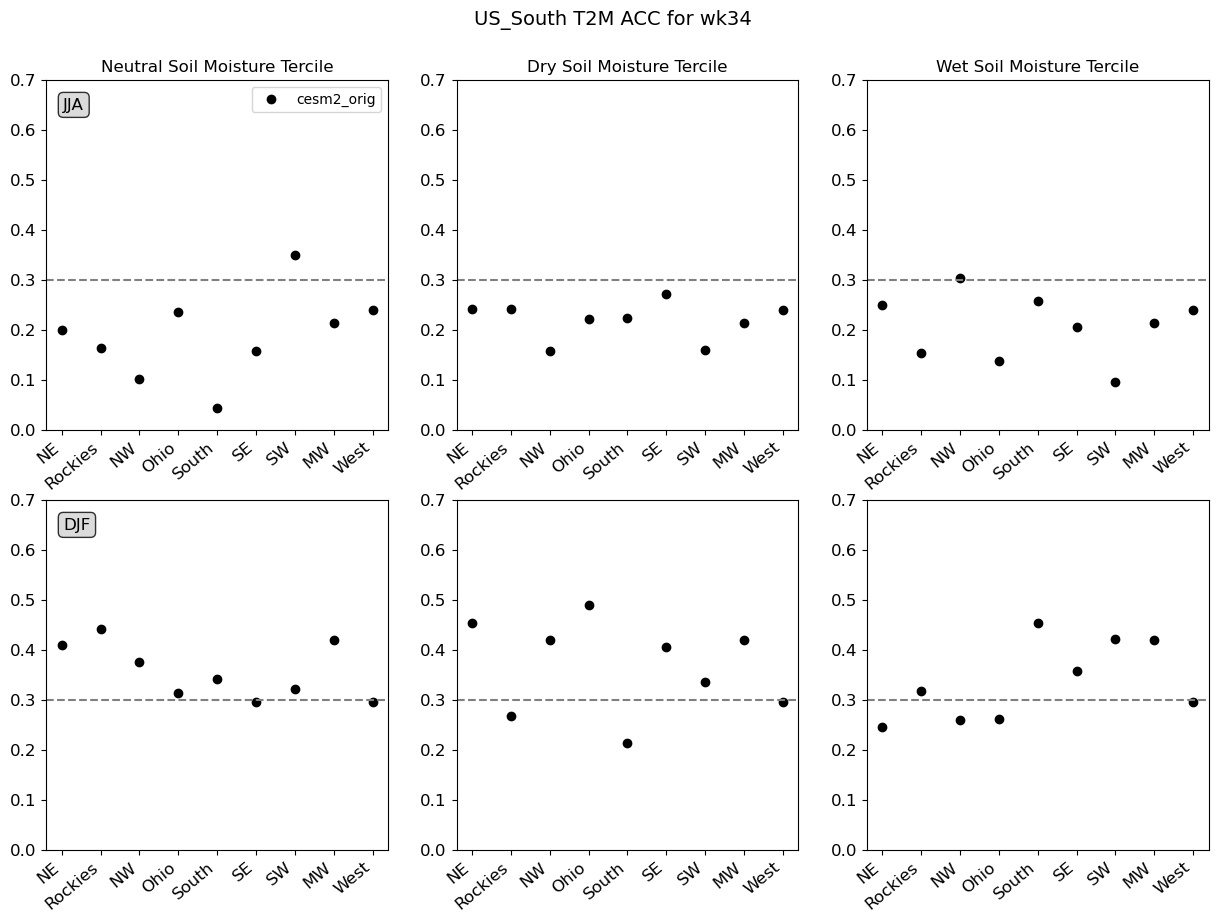

In [76]:
fig,axs = plt.subplots(2,3,figsize=(15,10))
axs = axs.ravel()

tickRange  = np.arange(len(np.where(state_labels=='dry')[0]))

## Neutral conditions
# for iReg in range(len(tickRange)):
#     axs[0].plot([tickRange[iReg],
#               tickRange[iReg]], 
#             [cesm2_orig_values_JJA[np.where(state_labels=='neutral')[0]][iReg],
#              cesm2_climoLND_values_JJA[np.where(state_labels=='neutral')[0]][iReg]],'gray')
axs[0].plot(tickRange, cesm2_orig_values_JJA[np.where(state_labels=='neutral')[0]], 'ko', label='cesm2_orig')
# axs[0].plot(tickRange, cesm2_climoLND_values_JJA[np.where(state_labels=='neutral')[0]], 'o',color='limegreen', label='cesm2_climoLND')
axs[0].legend()
axs[0].set_title('Neutral Soil Moisture Tercile')
axs[0].text(0.05, 0.95, 'JJA', 
        transform=axs[0].transAxes,  # Use axes coordinates (0-1)
        fontsize=12,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

# for iReg in range(len(tickRange)):
#     axs[3].plot([tickRange[iReg],
#               tickRange[iReg]], 
#             [cesm2_orig_values_DJF[np.where(state_labels=='neutral')[0]][iReg],
#              cesm2_climoLND_values_DJF[np.where(state_labels=='neutral')[0]][iReg]],'gray')
axs[3].plot(tickRange, cesm2_orig_values_DJF[np.where(state_labels=='neutral')[0]], 'ko', label='cesm2_orig')
# axs[3].plot(tickRange, cesm2_climoLND_values_DJF[np.where(state_labels=='neutral')[0]], 'o',color='limegreen', label='cesm2_climoLND')
axs[3].text(0.05, 0.95, 'DJF', 
        transform=axs[3].transAxes,  # Use axes coordinates (0-1)
        fontsize=12,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))


## Dry conditions
# for iReg in range(len(tickRange)):
#     axs[1].plot([tickRange[iReg],
#               tickRange[iReg]], 
#             [cesm2_orig_values_JJA[np.where(state_labels=='dry')[0]][iReg],
#              cesm2_climoLND_values_JJA[np.where(state_labels=='dry')[0]][iReg]],'gray')
axs[1].plot(tickRange, cesm2_orig_values_JJA[np.where(state_labels=='dry')[0]], 'ko', label='cesm2_orig')
# axs[1].plot(tickRange, cesm2_climoLND_values_JJA[np.where(state_labels=='dry')[0]], 'o',color='limegreen', label='cesm2_climoLND')
axs[1].set_title('Dry Soil Moisture Tercile')


# for iReg in range(len(tickRange)):
#     axs[4].plot([tickRange[iReg],
#               tickRange[iReg]], 
#             [cesm2_orig_values_DJF[np.where(state_labels=='dry')[0]][iReg],
#              cesm2_climoLND_values_DJF[np.where(state_labels=='dry')[0]][iReg]],'gray')
axs[4].plot(tickRange, cesm2_orig_values_DJF[np.where(state_labels=='dry')[0]], 'ko', label='cesm2_orig')
# axs[4].plot(tickRange, cesm2_climoLND_values_DJF[np.where(state_labels=='dry')[0]], 'o',color='limegreen', label='cesm2_climoLND')

## Wet conditions
# for iReg in range(len(tickRange)):
#     axs[2].plot([tickRange[iReg],
#               tickRange[iReg]], 
#             [cesm2_orig_values_JJA[np.where(state_labels=='wet')[0]][iReg],
#              cesm2_climoLND_values_JJA[np.where(state_labels=='wet')[0]][iReg]],'gray')
axs[2].plot(tickRange, cesm2_orig_values_JJA[np.where(state_labels=='wet')[0]], 'ko', label='cesm2_orig')
# axs[2].plot(tickRange, cesm2_climoLND_values_JJA[np.where(state_labels=='wet')[0]], 'o',color='limegreen', label='cesm2_climoLND')
axs[2].set_title('Wet Soil Moisture Tercile')

# for iReg in range(len(tickRange)):
#     axs[5].plot([tickRange[iReg],
#               tickRange[iReg]], 
#             [cesm2_orig_values_DJF[np.where(state_labels=='wet')[0]][iReg],
#              cesm2_climoLND_values_DJF[np.where(state_labels=='wet')[0]][iReg]],'gray')
axs[5].plot(tickRange, cesm2_orig_values_DJF[np.where(state_labels=='wet')[0]], 'ko', label='cesm2_orig')
# axs[5].plot(tickRange, cesm2_climoLND_values_DJF[np.where(state_labels=='wet')[0]], 'o',color='limegreen', label='cesm2_climoLND')

axs[1].text(0.05, 1.20, 'US_South T2M ACC for '+weeks[1], 
        transform=axs[1].transAxes,  # Use axes coordinates (0-1)
        fontsize=14,
        verticalalignment='top')

[a.set_xticks(tickRange) for a in axs]
[a.set_xticklabels(plot_labels[np.where(state_labels=='wet')]) for a in axs]
[plt.setp( a.xaxis.get_majorticklabels(), rotation=40, ha='right' ) for a in axs]
# [a.axhline(0.5, linestyle='--',color='grey') for a in axs]
[a.axhline(0.3, linestyle='--',color='grey') for a in axs]
# [a.set_ylim([0.1, 0.7]) for a in axs]
[a.set_ylim([0.0, 0.7]) for a in axs]
[a.tick_params(axis='both', which='major', labelsize=12) for a in axs]

plt.show()   


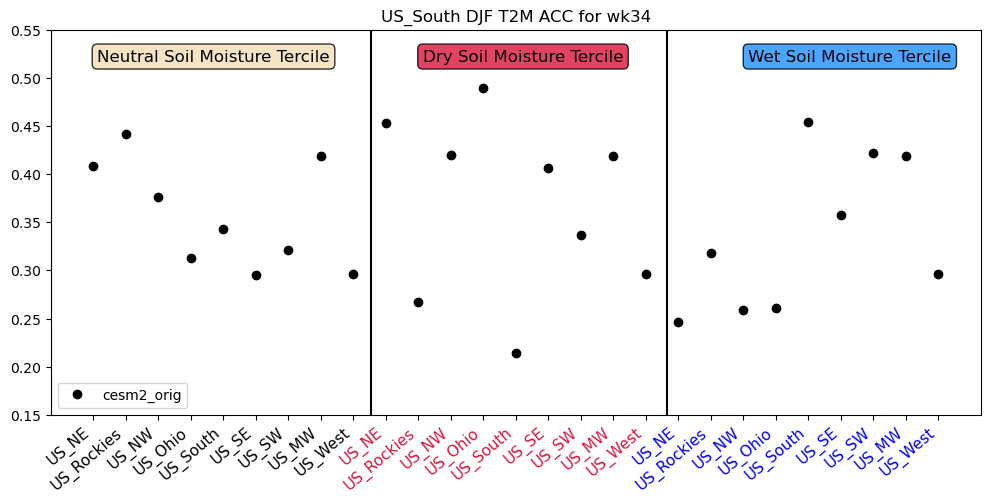

In [117]:
fig,axs = plt.subplots(1,1,figsize=(12,5))

# for iReg in range(len(plot_labels)):
#     axs.plot([heat_array.isel(lead=1).sel(regions='US_South').regions_state.values[iReg],
#               heat_array.isel(lead=1).sel(regions='US_South').regions_state.values[iReg]], 
#             [cesm2_orig_values[iReg],
#              heat_array.isel(lead=1).sel(regions='US_South').values[iReg]],'gray')
    
axs.plot(heat_array.isel(lead=1).sel(regions='US_South').regions_state, cesm2_orig_values, 
         'ko', label='cesm2_orig')
# axs.plot(heat_array.isel(lead=1).sel(regions='US_South').regions_state, heat_array.isel(lead=1).sel(regions='US_South').values, 
#          'o',color='limegreen', label='cesm2_climoLND')


axs.legend()

axs.set_title('US_South '+season+' T2M ACC for '+weeks[1])


ticks = np.arange(len(plot_labels))
axs.set_xticks(ticks)
axs.set_xticklabels(plot_labels, fontsize=11)
plt.setp( axs.xaxis.get_majorticklabels(), rotation=40,ha='right' )

# Get the tick labels
labels = axs.get_xticklabels()
n = len(labels)
for i, label in enumerate(labels):
    if i < n // 3:
        label.set_color('black')  # or whatever color you want for first third
    elif i < 2 * n // 3:
        label.set_color('crimson')
    else:
        label.set_color('blue')

axs.axvline(np.where(state_labels=='dry')[0][0]*0.95,color='k')
axs.axvline(np.where(state_labels=='wet')[0][0]*0.98,color='k')

axs.set_ylim([0.15, 0.55])

axs.text(0.05, 0.95, 'Neutral Soil Moisture Tercile', 
        transform=axs.transAxes,  # Use axes coordinates (0-1)
        fontsize=12,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
axs.text(0.4, 0.95, 'Dry Soil Moisture Tercile', 
        transform=axs.transAxes,  # Use axes coordinates (0-1)
        fontsize=12,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='crimson', alpha=0.8))
axs.text(0.75, 0.95, 'Wet Soil Moisture Tercile', 
        transform=axs.transAxes,  # Use axes coordinates (0-1)
        fontsize=12,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='dodgerblue', alpha=0.8))

plt.show()        


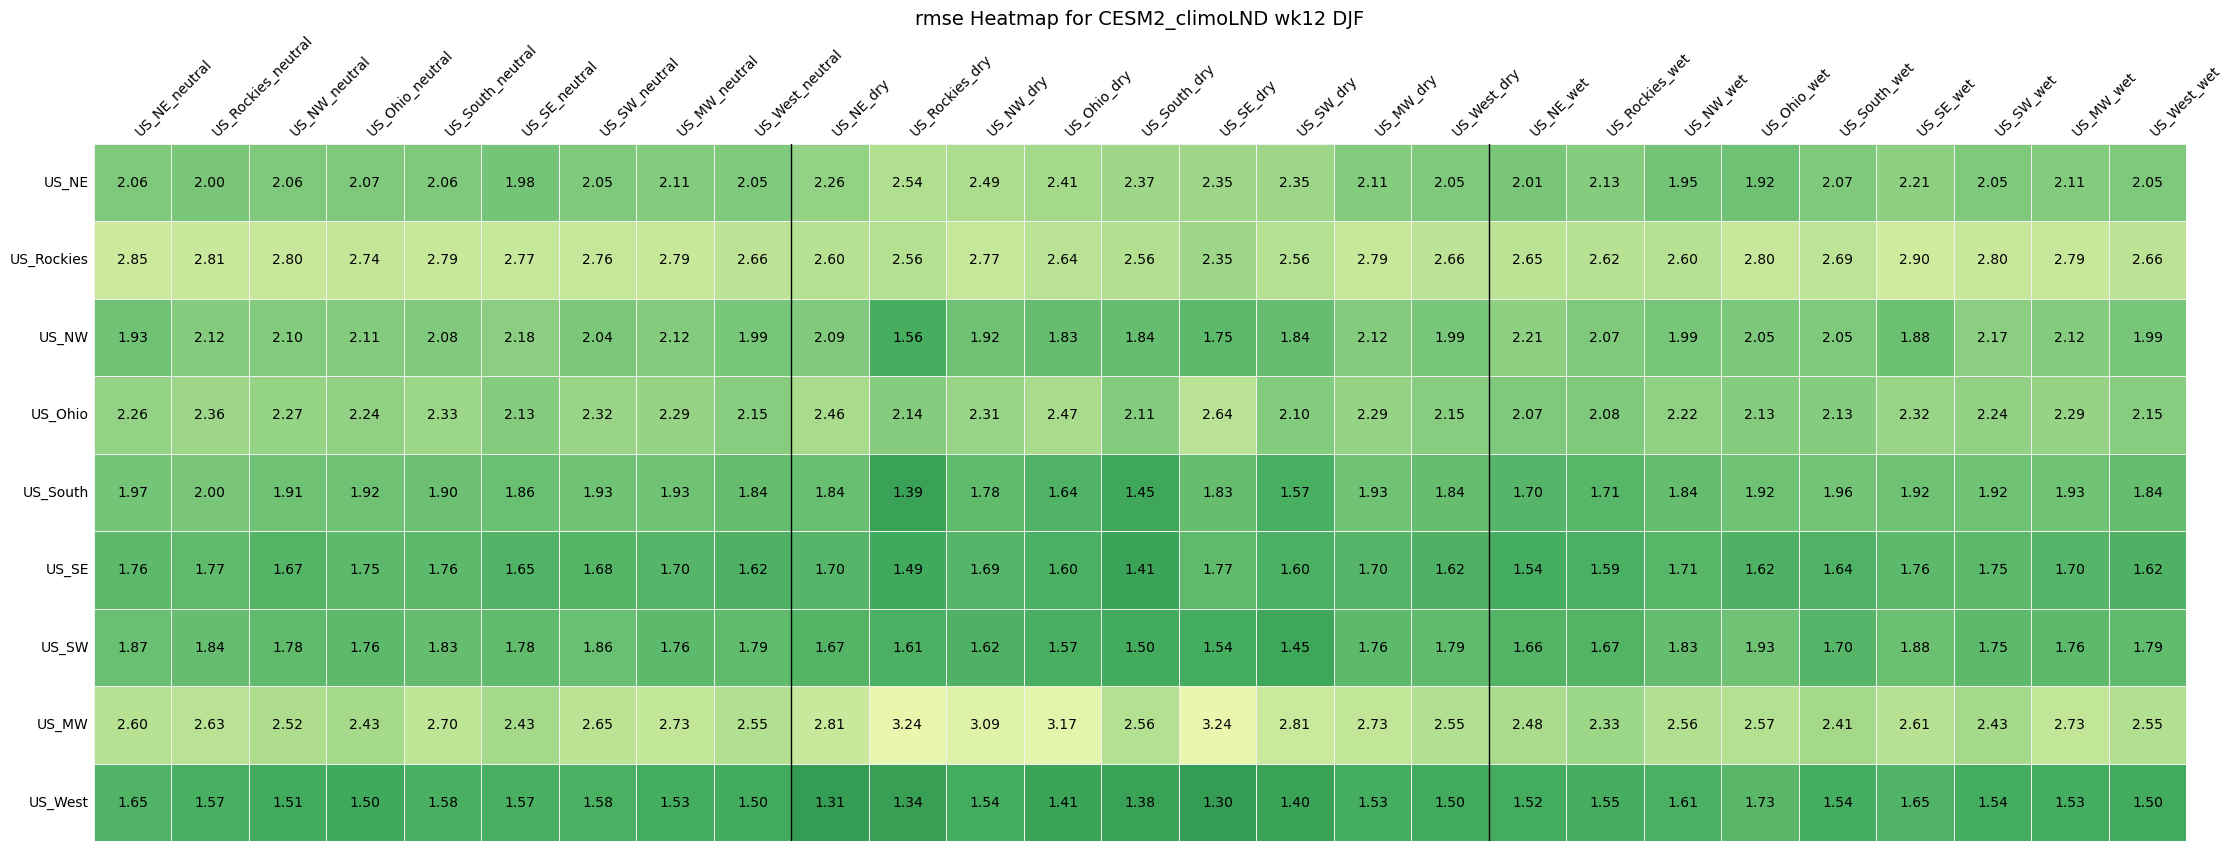

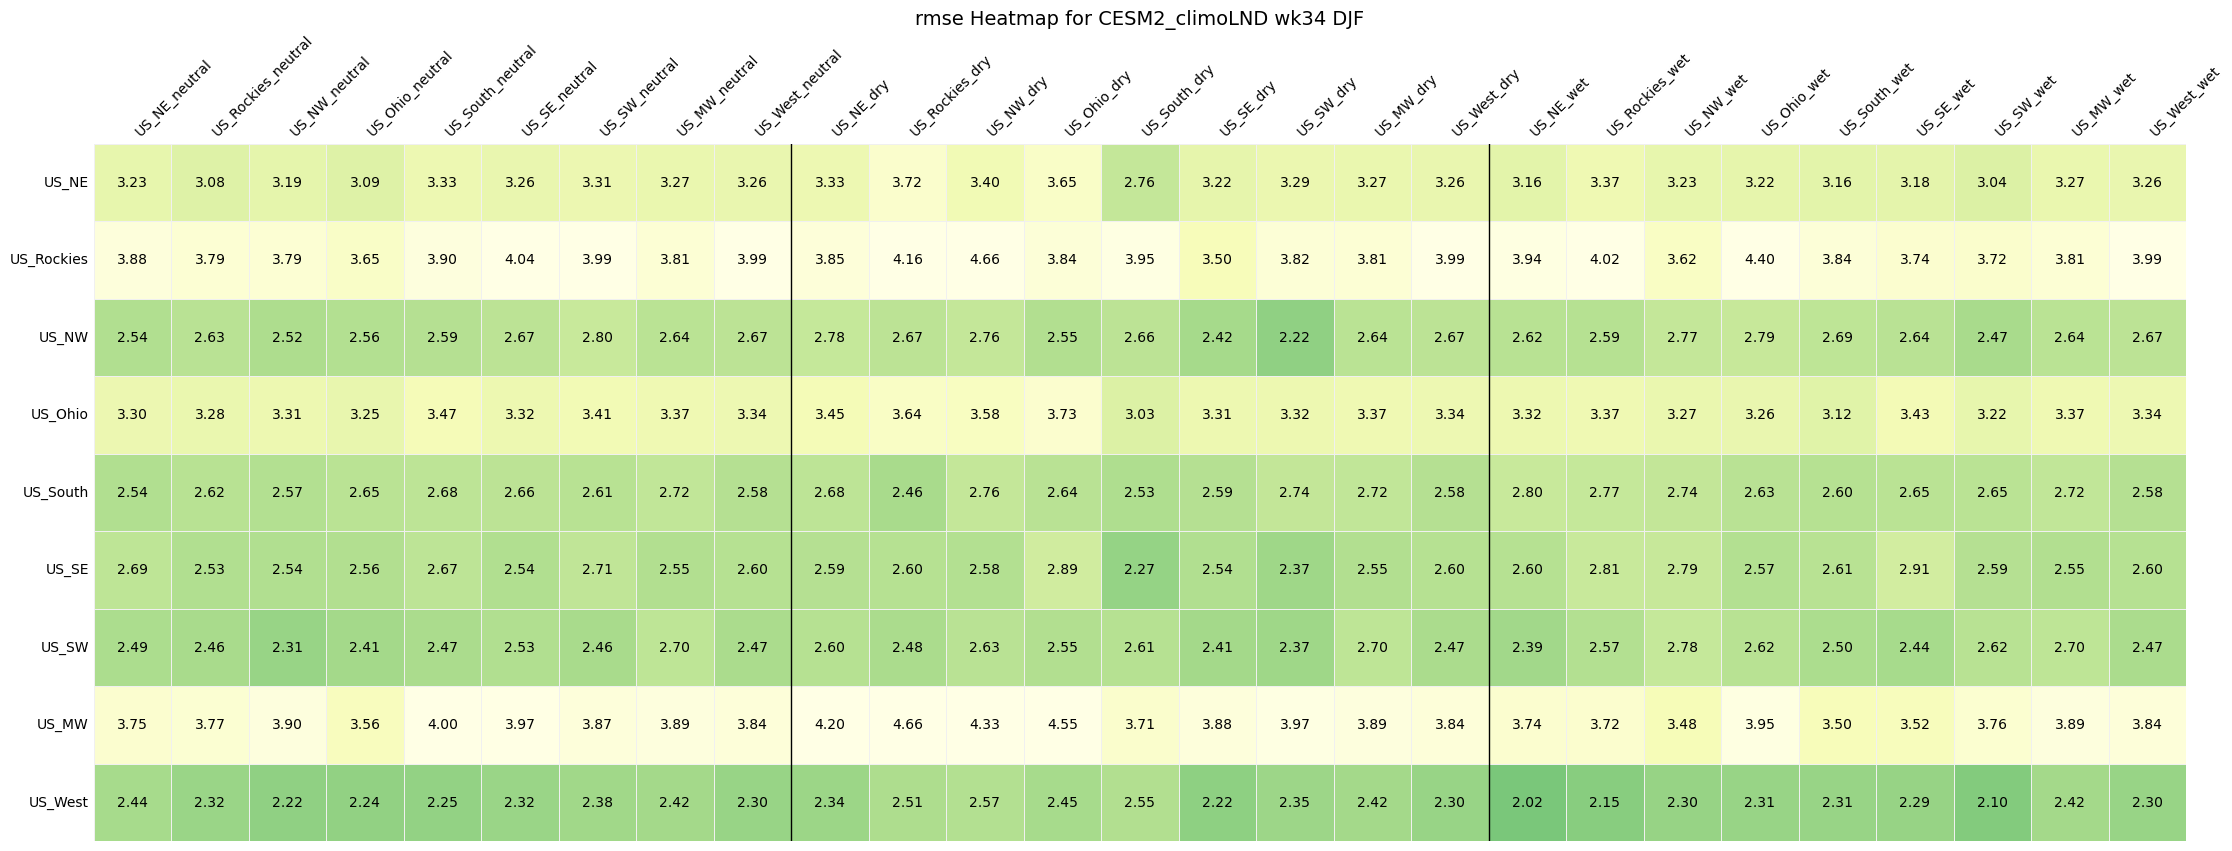

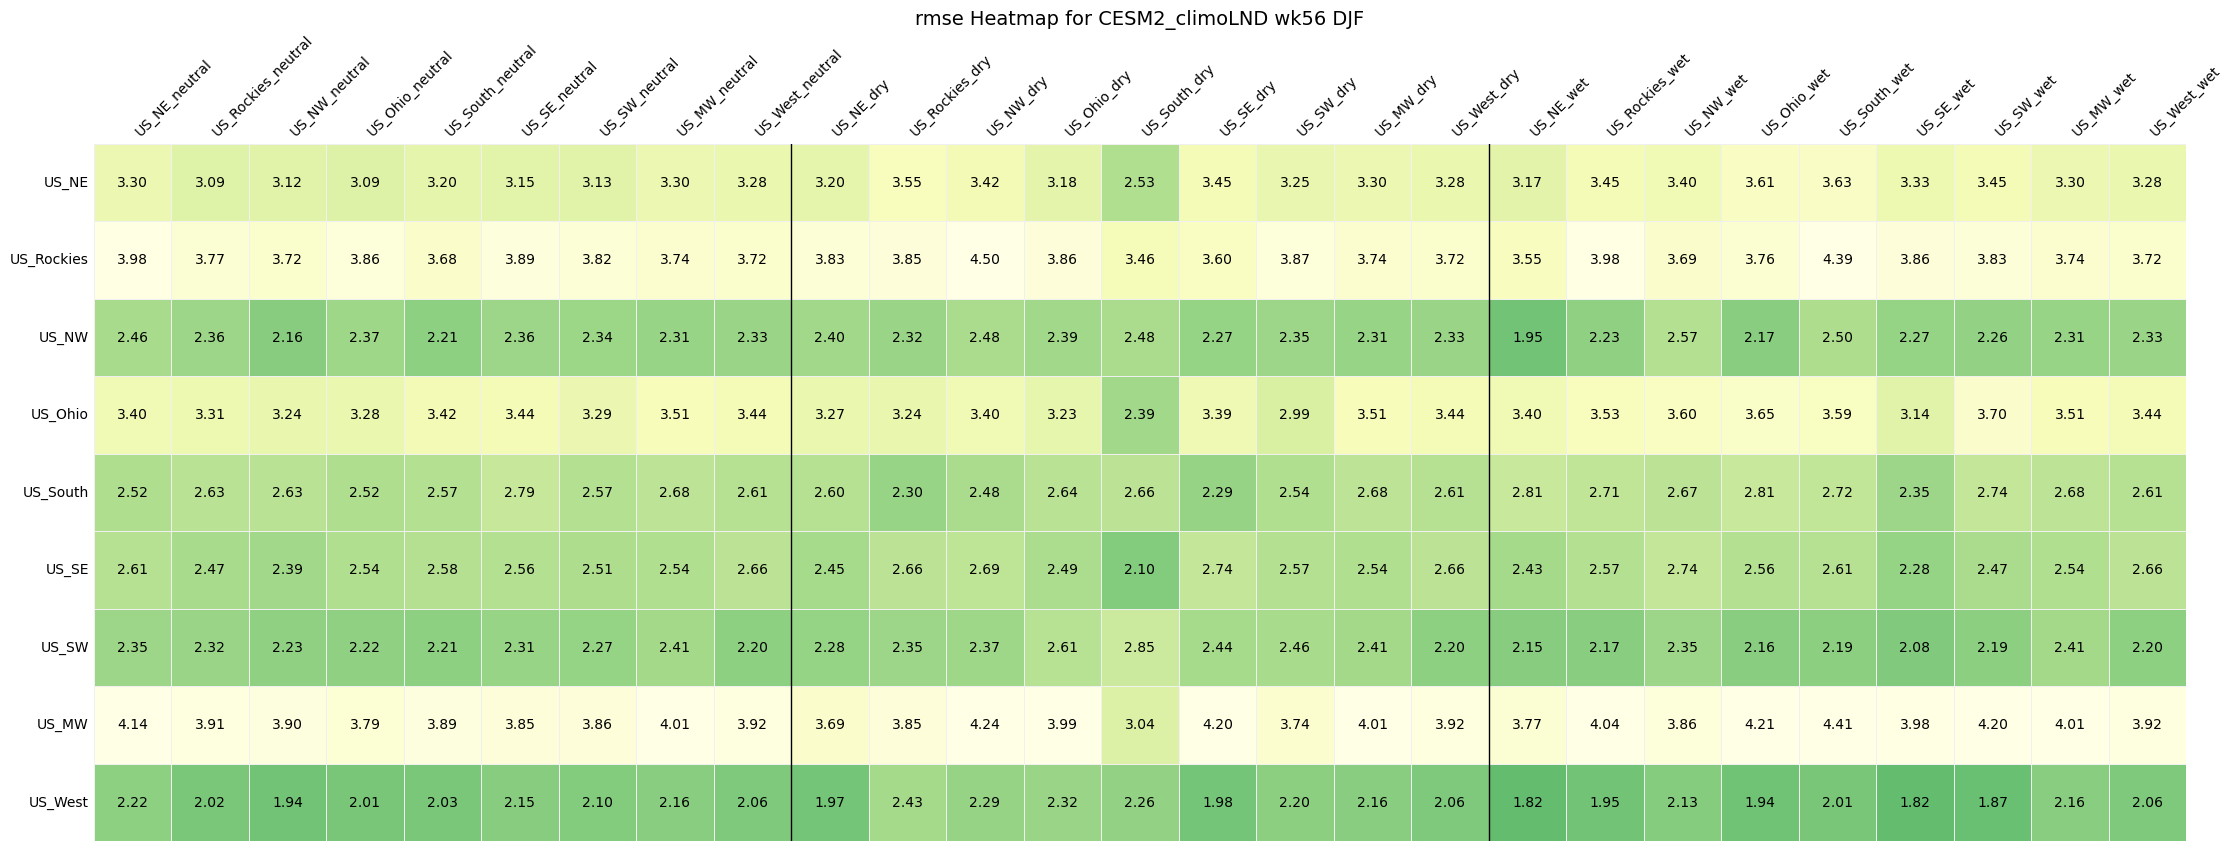

In [46]:
for l in range(0,3):
    plt.figure(figsize=(27,10))
    ax = sns.heatmap(heat_array.sel(lead=ld[l]), annot=True,  fmt=".2f",xticklabels=heat_array.coords['regions_state'].values,\
                     yticklabels=heat_array.coords['regions'].values,square=True,linewidths=.5,linecolor='#F0F0F0',cbar=False,\
                     annot_kws={"color": "black","fontsize": 10},
                     cmap='YlGn_r', vmin=0,vmax=4)  # RMSE
                     # cmap='RdBu_r', vmin=-0.75,vmax=0.75)  # ACC
    ax.xaxis.set_ticks_position('top') 
    ax.xaxis.set_label_position('top')
    plt.xticks(rotation=45, ha='left')
    plt.yticks(rotation=0, ha='right')
    ax.tick_params(axis='both', which='both', length=0)
    ax.grid(False)

    section_boundaries = [9,18]
    for boundary in section_boundaries:
        plt.axvline(x=boundary, color='black', linestyle='-', linewidth=1)
    
    plt.title(metric+" Heatmap for "+models[0]+" "+weeks[l]+" "+season, fontsize=14)
    if savefig=="yes":
        plt.savefig(plotdir+"heatmap_"+models[0]+"_"+weeks[l]+"_"+season+".jpg",dpi=300,bbox_inches="tight")

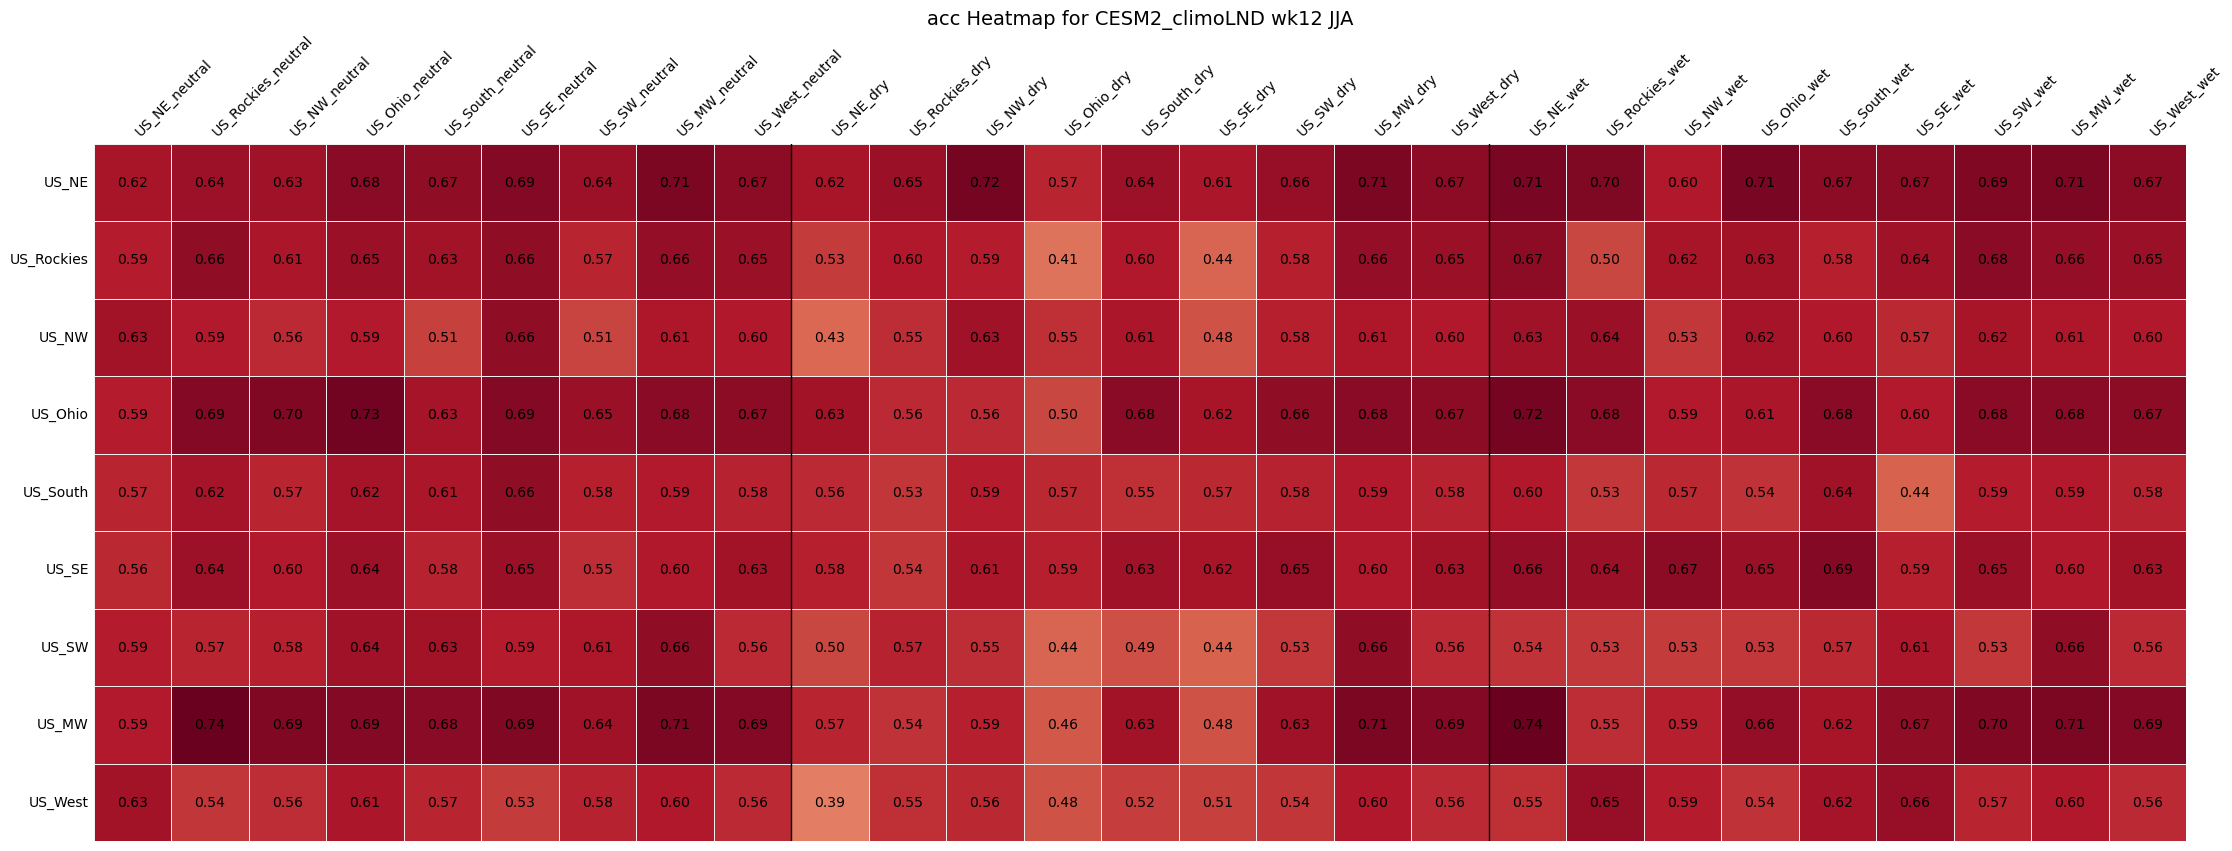

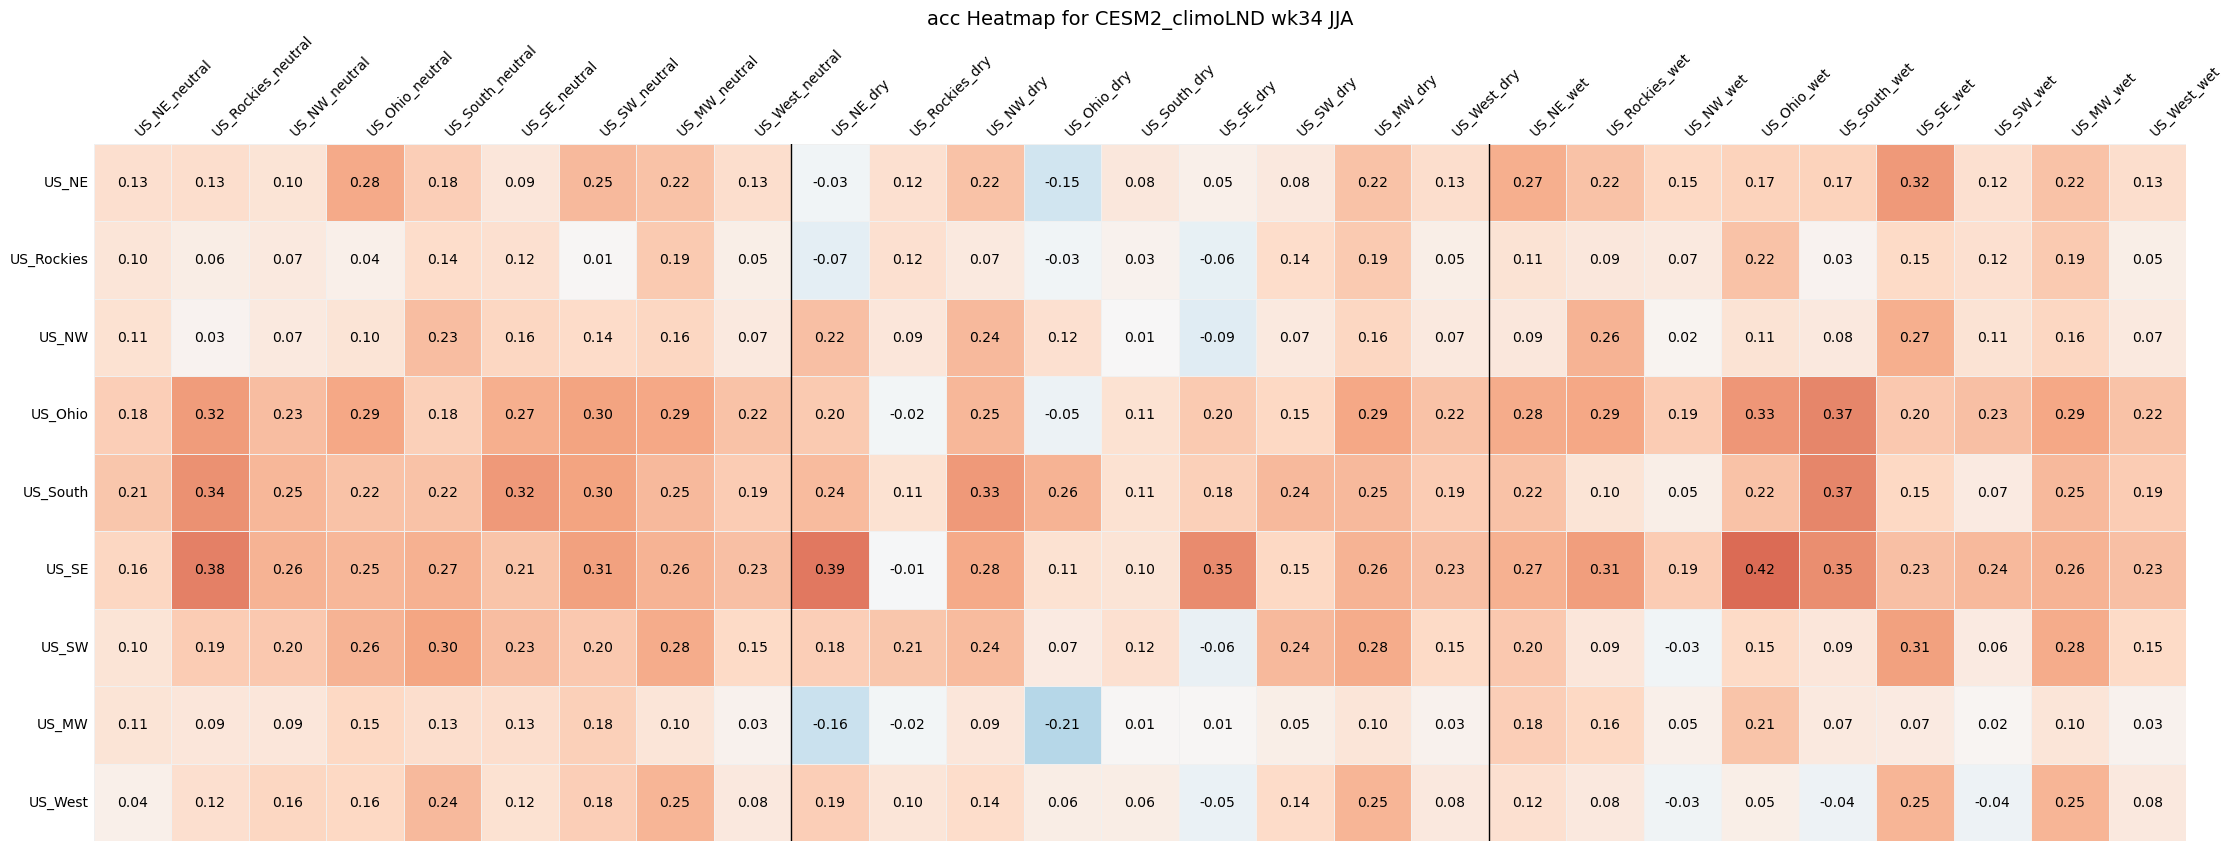

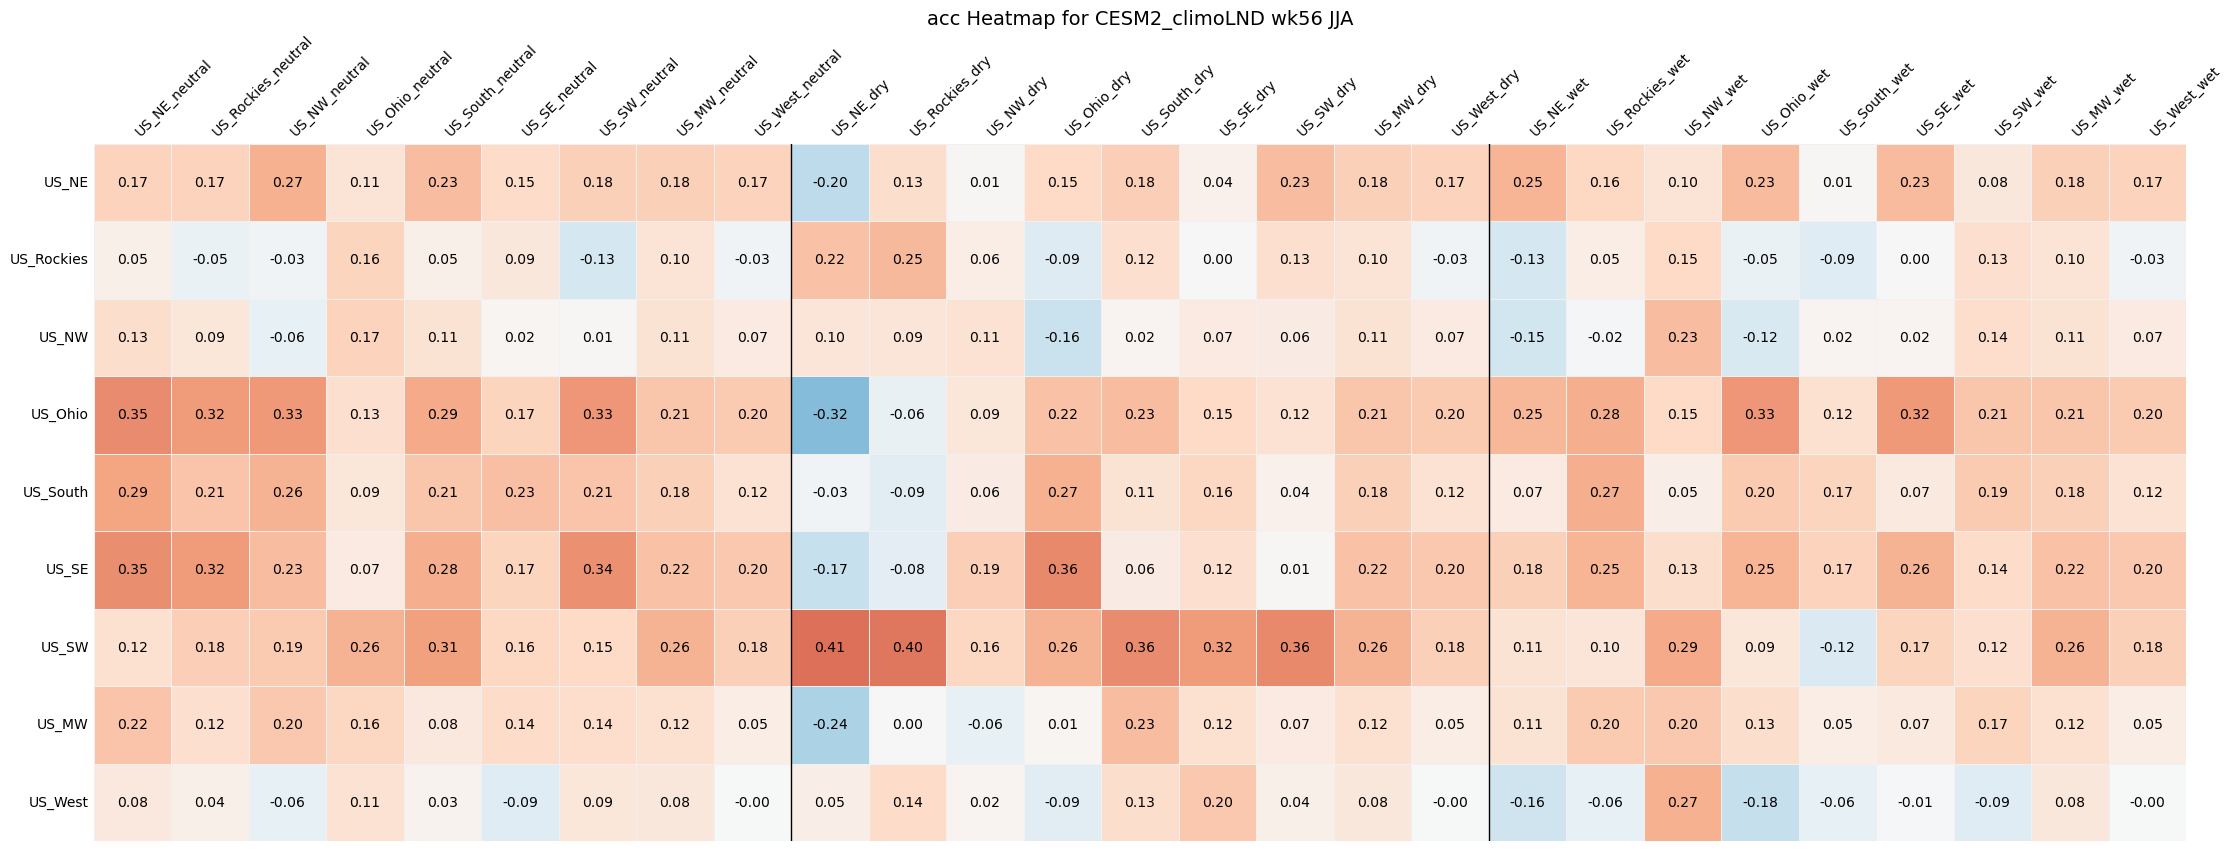

In [20]:
for l in range(0,3):
    plt.figure(figsize=(27,10))
    ax = sns.heatmap(heat_array.sel(lead=ld[l]), annot=True,  fmt=".2f",xticklabels=heat_array.coords['regions_state'].values,\
                     yticklabels=heat_array.coords['regions'].values,square=True,linewidths=.5,linecolor='#F0F0F0',cbar=False,\
                     annot_kws={"color": "black","fontsize": 10},
                     # cmap='YlGn_r', vmin=0,vmax=4)  # RMSE
                     cmap='RdBu_r', vmin=-0.75,vmax=0.75)  # ACC
    ax.xaxis.set_ticks_position('top') 
    ax.xaxis.set_label_position('top')
    plt.xticks(rotation=45, ha='left')
    plt.yticks(rotation=0, ha='right')
    ax.tick_params(axis='both', which='both', length=0)
    ax.grid(False)

    section_boundaries = [9,18]
    for boundary in section_boundaries:
        plt.axvline(x=boundary, color='black', linestyle='-', linewidth=1)
    
    plt.title(metric+" Heatmap for "+models[0]+" "+weeks[l]+" "+season, fontsize=14)
    if savefig=="yes":
        plt.savefig(plotdir+"heatmap_"+models[0]+"_"+weeks[l]+"_"+season+".jpg",dpi=300,bbox_inches="tight")

In [63]:
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import xarray as xr
import os
from matplotlib.patches import Patch
from matplotlib import colors as mcolors
import warnings
warnings.filterwarnings('ignore')


def create_skill_maps_for_region(region_idx, heatmap_all, shapefiles, shapefile_dir, 
                                  region_names=None, output_dir='skill_maps', lead_time=0):
    """
    Create a 3-panel map showing T2M prediction skill for a specific region
    under neutral, wet, and dry conditions.
    
    Parameters:
    -----------
    region_idx : int
        Index of the region of interest (0-18 for 19 regions)
    all_skill_data : dict
        Dictionary from parse_skill_data with structure:
        {region_idx: {'neutral': array, 'wet': array, 'dry': array}}
    shapefiles : list
        List of shapefile paths/names
    shapefile_dir : str
        Directory containing shapefiles
    region_names : list, optional
        Names for each region (default: uses shapefile basenames)
    output_dir : str
        Directory to save output figures
    lead_time : int, optional
        Lead time index (for labeling)
    """
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Get region names if not provided
    if region_names is None:
        region_names = [os.path.splitext(os.path.basename(shp))[0] for shp in shapefiles]
    
    # Get skill data for this specific region
    # skill_data_dict = all_skill_data[region_idx]
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Get region names if not provided
    if region_names is None:
        region_names = [os.path.splitext(os.path.basename(shp))[0] for shp in shapefiles]
    
    # Create figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 8))
    conditions = ['neutral', 'wet', 'dry']
    condition_titles = ['Neutral Conditions', 'Wet Conditions', 'Dry Conditions']
    
    # Define colormap for skill (e.g., correlation: -1 to 1, or accuracy: 0 to 1)
    # Adjust vmin, vmax based on your skill metric
    skill_cmap = plt.cm.RdBu_r  # Red (bad) to Green (good)
    vmin, vmax = -0.75, 0.75  # Adjust based on your metric (e.g., 0, 1 for accuracy)
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    
    for idx, (ax, condition, title) in enumerate(zip(axes, conditions, condition_titles)):
        
        # Get skill data for this condition
        # skill_values = skill_data_dict[condition]
        skill_String = heat_array.regions.values[region_idx]+'_'+condition
        skill_values = heatmap_all.sel(regions_state=skill_String).isel(lead=lead_time).values
        
        # Add basemap (states/coastlines)
        add_basemap(ax)
            
        # Plot each basin/region
        for i, shp_path in enumerate(shapefiles):
            # Read the shapefile
            gdf = gpd.read_file(os.path.join(shapefile_dir, shp_path))
            
            # Get skill value for this region
            skill = skill_values[i]
            
            # Determine color based on skill
            face_color = skill_cmap(norm(skill))
            
            # Determine edge properties (bold outline for region of interest)
            if i == region_idx:
                edge_color = 'black'
                edge_width = 4.0
                alpha = 0.9
            else:
                edge_color = 'black'
                edge_width = 0.8
                alpha = 0.7
            
            # Plot the shapefile
            gdf.plot(ax=ax, color=face_color, edgecolor=edge_color, 
                    linewidth=edge_width, alpha=alpha)
            
            # Add skill value text at centroid
            centroid = gdf.geometry.centroid.iloc[0]
            ax.text(centroid.x, centroid.y, f'{skill:.2f}', 
                   fontsize=9, ha='center', va='center',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                            edgecolor='black', alpha=0.8),
                   fontweight='bold' if i == region_idx else 'normal')
        
        # Set CONUS extent
        ax.set_xlim(-125, -66)
        ax.set_ylim(24, 53)

        # Add title
        ax.set_title(f'{title}\n(Region: {region_names[region_idx]})', 
                    fontsize=14, fontweight='bold')
        ax.set_xlabel('Longitude', fontsize=11)
        ax.set_ylabel('Latitude', fontsize=11)
        
        # Add gridlines
        ax.grid(True, alpha=0.2, linestyle='--', linewidth=0.5)
    
    # Add a shared colorbar
    cbar_ax = fig.add_axes([0.92, 0.2, 0.015, 0.5])
    sm = plt.cm.ScalarMappable(cmap=skill_cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label('T2M Prediction Skill', fontsize=12, fontweight='bold')
    
    # Overall title
    lead_str = f' ( {models[0]} {season} Lead Time: {weeks[lead_time]})' if lead_time is not None else ''
    fig.suptitle(f'T2M Prediction Skill by Precipitation Condition{lead_str}\nFocus Region: {region_names[region_idx]}', 
                fontsize=16, fontweight='bold', y=0.8)
    
    # plt.tight_layout(rect=[0, 0, 0.91, 0.92])
    
    # Save figure
    lead_suffix = f'_lead{lead_time}' if lead_time is not None else ''
    output_path = os.path.join(output_dir, f'skill_map_{models[0]}_region_{region_names[region_idx]}{lead_suffix}_{season}.png')
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"Saved: {output_path}")
    
    return fig, axes


def add_basemap(ax):
    """Add US states and coastlines to the axis."""
    try:
        # Load US states
        states_url = "https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_20m.zip"
        states = gpd.read_file(states_url)
        
        # Filter for CONUS
        conus_states = states[~states['STUSPS'].isin(['AK', 'HI', 'PR', 'VI', 'GU', 'MP', 'AS'])]
        
        # Plot states
        conus_states.plot(ax=ax, color='none', edgecolor='gray', linewidth=0.5, alpha=0.6)
        
        # Plot coastlines
        conus_states.dissolve().boundary.plot(ax=ax, edgecolor='black', linewidth=1.5)
        
    except Exception as e:
        print(f"Could not load states: {e}")
        try:
            import cartopy.crs as ccrs
            import cartopy.feature as cfeature
            ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.5)
            ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=1.5)
        except:
            print("Could not add basemap features")


def create_all_region_maps(all_skill_data, shapefiles, shapefile_dir, 
                           region_names=None, output_dir='skill_maps', lead_time=None):
    """
    Create skill maps for all regions.
    
    Parameters:
    -----------
    all_skill_data : dict
        Dictionary from parse_skill_data with structure:
        {region_idx: {'neutral': array, 'wet': array, 'dry': array}}
    shapefiles : list
        List of shapefile paths
    shapefile_dir : str
        Directory containing shapefiles
    region_names : list, optional
        Names for regions
    output_dir : str
        Output directory
    lead_time : int, optional
        Lead time index (for labeling)
    """
    n_regions = len(shapefiles)
    
    for region_idx in range(n_regions):
        fig, axes = create_skill_maps_for_region(
            region_idx, all_skill_data, shapefiles, shapefile_dir,
            region_names, output_dir, lead_time
        )
        plt.close(fig)  # Close to free memory
    
    print(f"\nCreated {n_regions} skill map figures in '{output_dir}'")



In [64]:
shapefiles = [
    'US_Northeast.shp', 'US_NorthernRockies.shp', 'US_Northwest.shp', 'US_OhioValley.shp', 'US_South.shp', 
    'US_Southeast.shp', 'US_Southwest.shp', 'US_UpperMidwest.shp', 'US_West.shp'
]

shapefile_dir = '/glade/u/home/mdfowler/Analysis/S2S/SamarFiles'


Saved: skill_maps/skill_map_CESM2_climoATM_region_US_NE_lead1_JJA.png


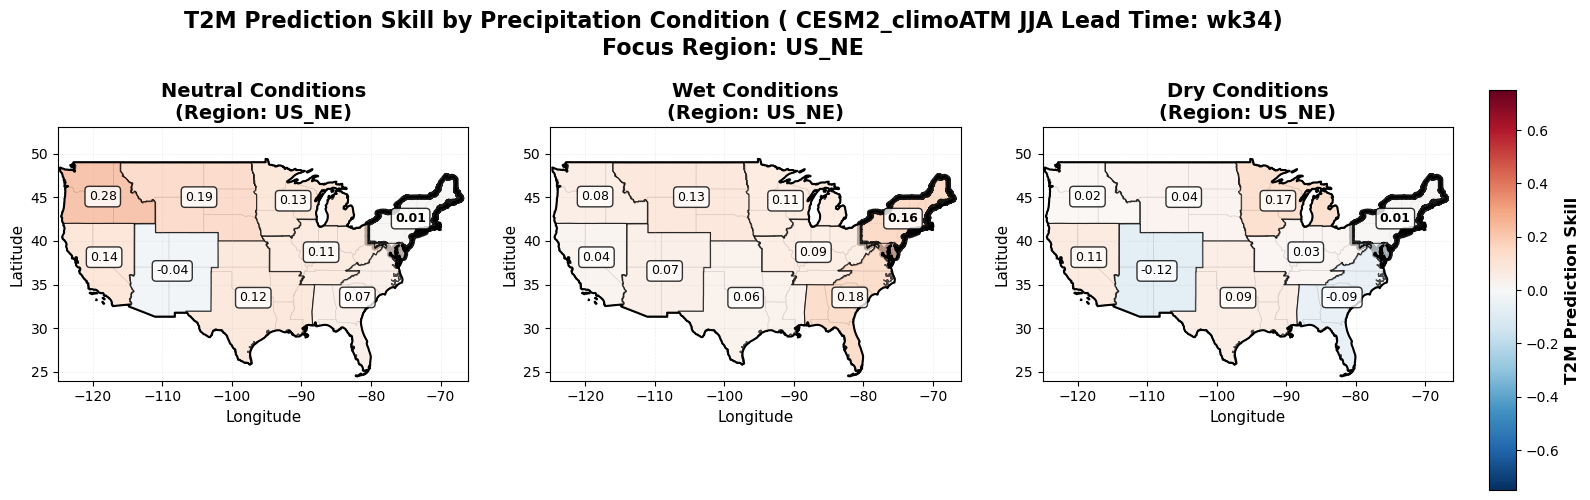

In [65]:
### Option 1: Single region, single lead time

fig, axes = create_skill_maps_for_region(
    region_idx=0,
    heatmap_all=heat_array,
    shapefiles=shapefiles,
    shapefile_dir=shapefile_dir,
    region_names=heat_array.regions.values,
    lead_time=1
)


Saved: skill_maps/skill_map_CESM2_climoATM_region_US_NE_lead1_JJA.png
Saved: skill_maps/skill_map_CESM2_climoATM_region_US_Rockies_lead1_JJA.png
Saved: skill_maps/skill_map_CESM2_climoATM_region_US_NW_lead1_JJA.png
Saved: skill_maps/skill_map_CESM2_climoATM_region_US_Ohio_lead1_JJA.png
Saved: skill_maps/skill_map_CESM2_climoATM_region_US_South_lead1_JJA.png
Saved: skill_maps/skill_map_CESM2_climoATM_region_US_SE_lead1_JJA.png
Saved: skill_maps/skill_map_CESM2_climoATM_region_US_SW_lead1_JJA.png
Saved: skill_maps/skill_map_CESM2_climoATM_region_US_MW_lead1_JJA.png
Saved: skill_maps/skill_map_CESM2_climoATM_region_US_West_lead1_JJA.png


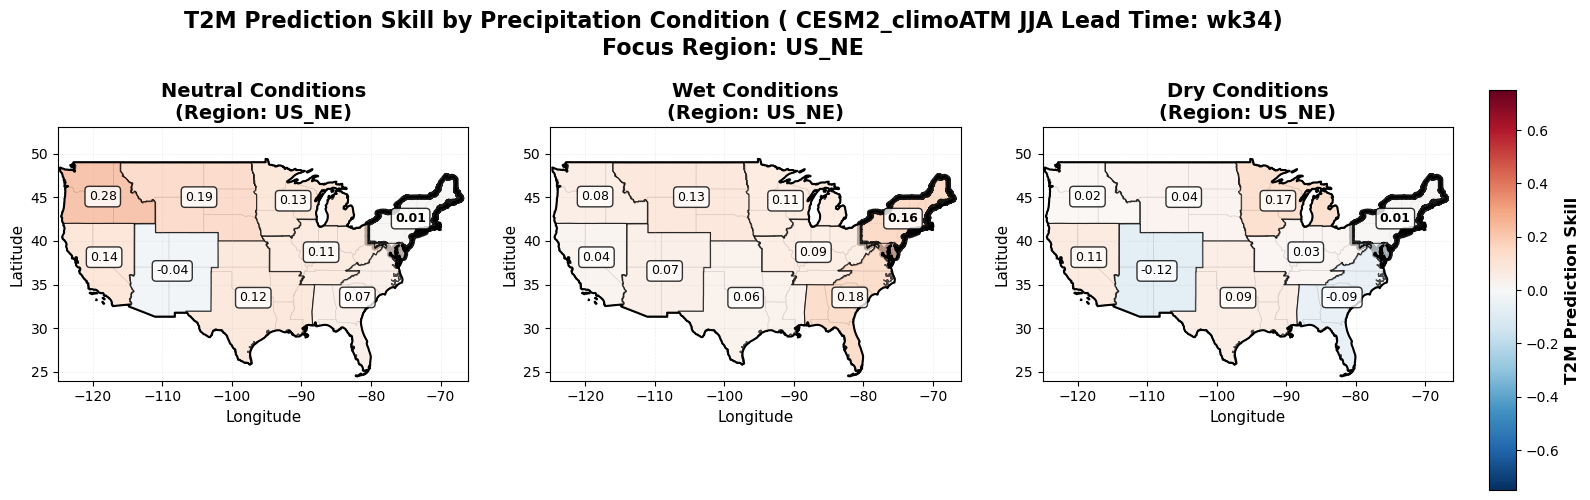

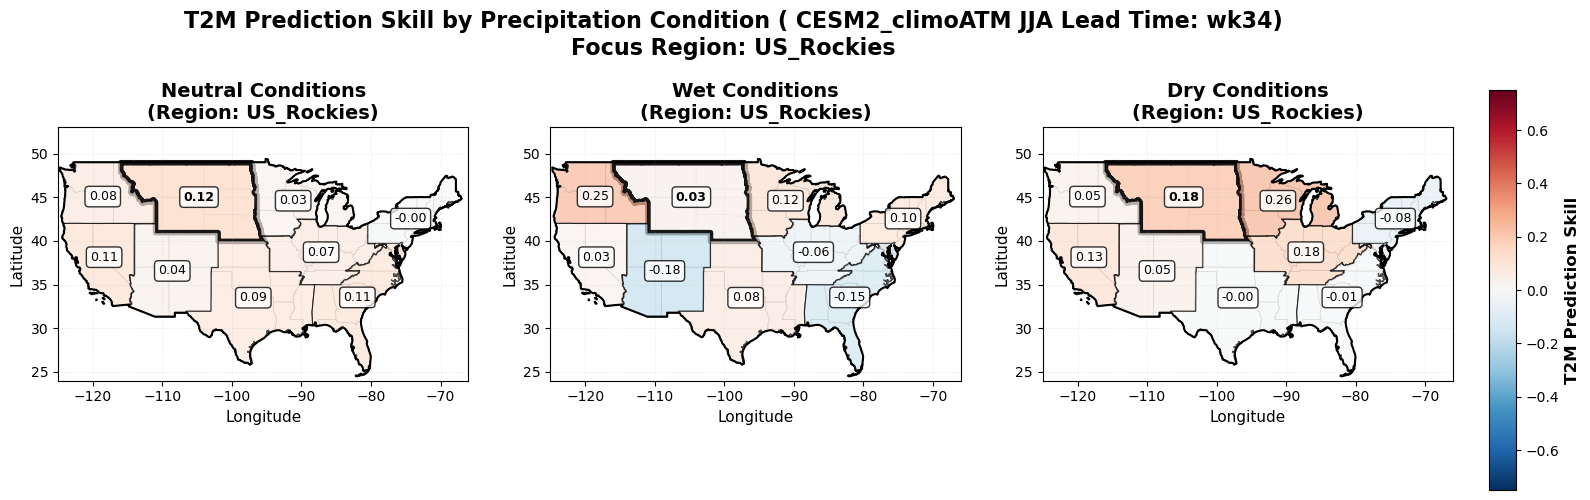

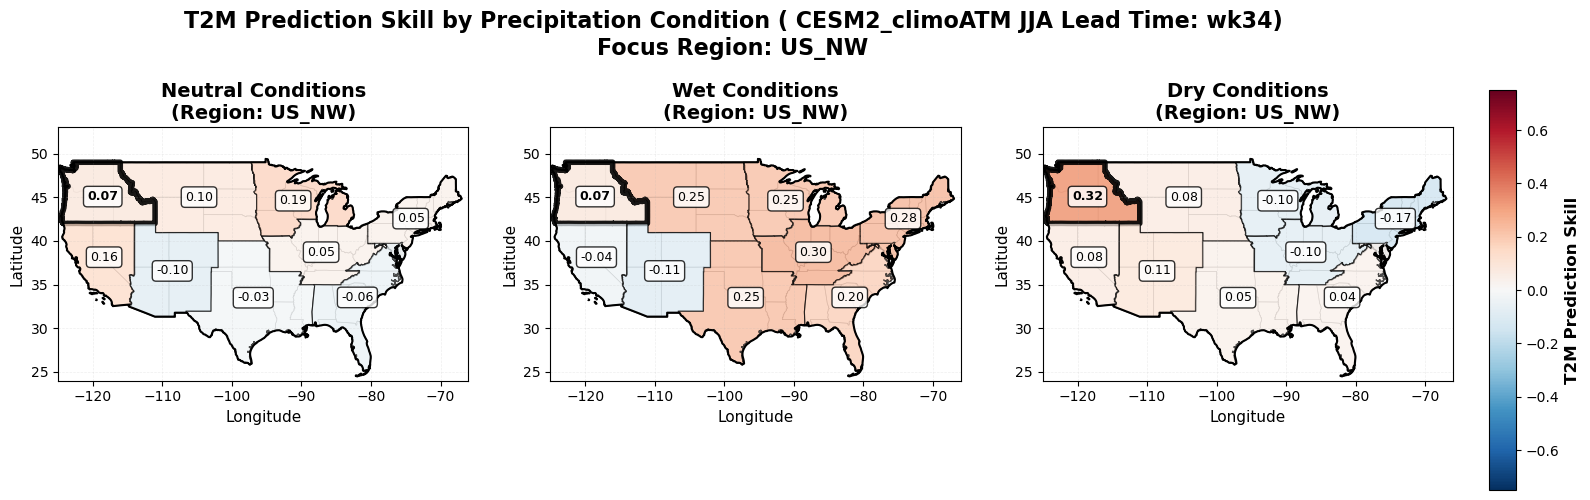

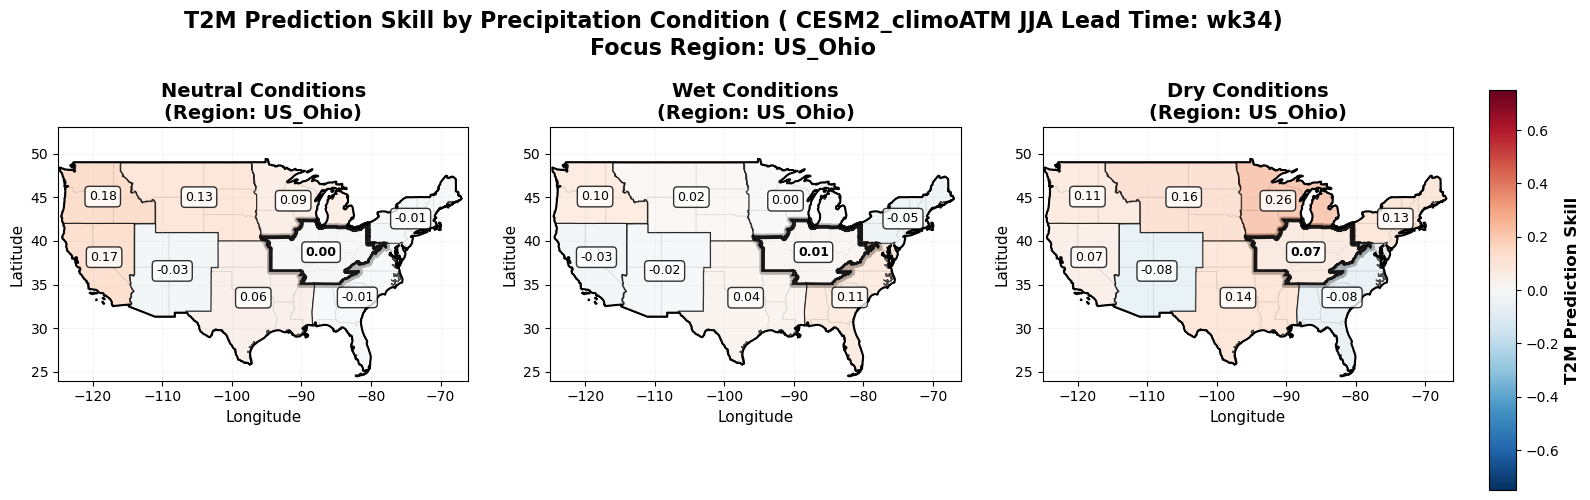

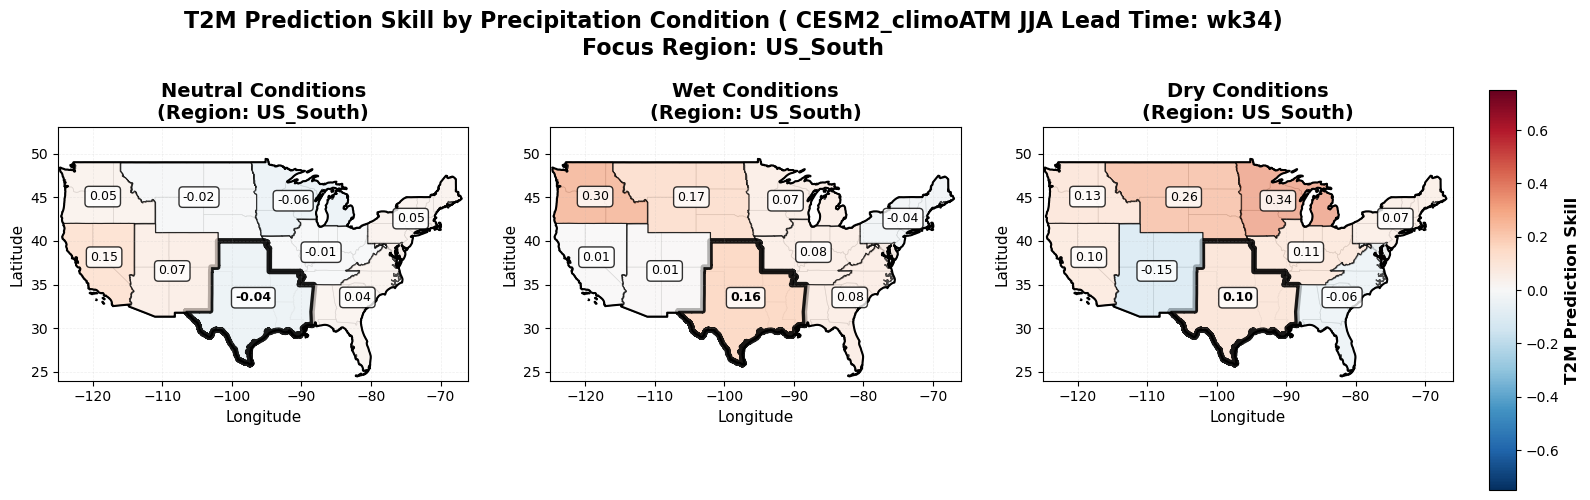

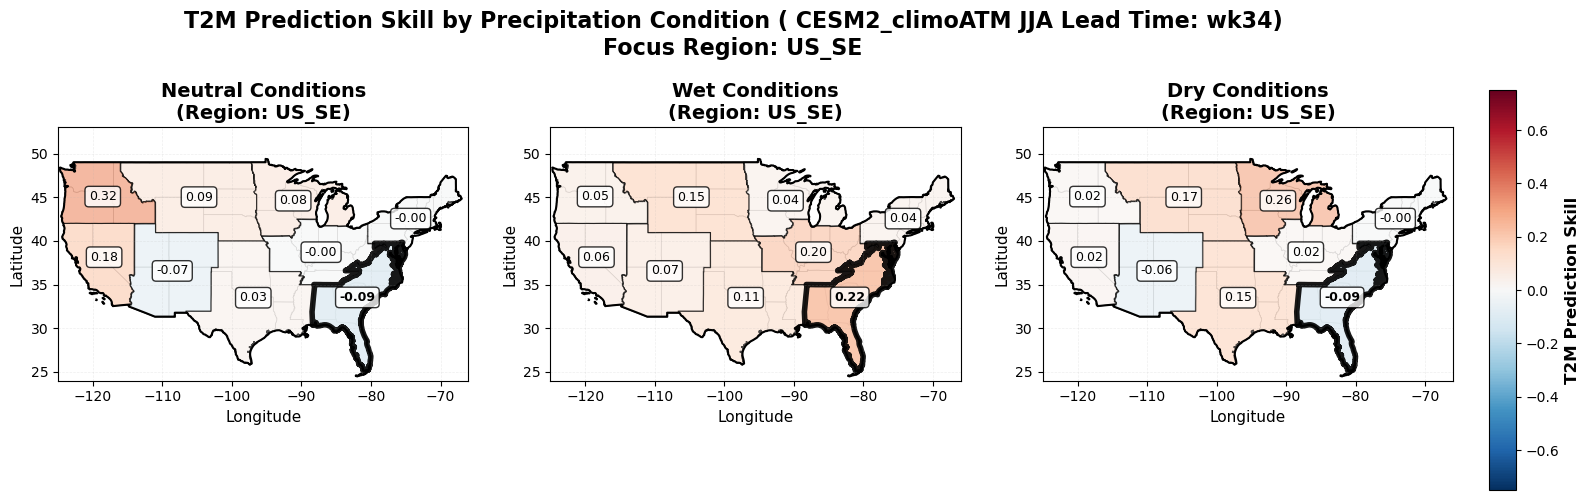

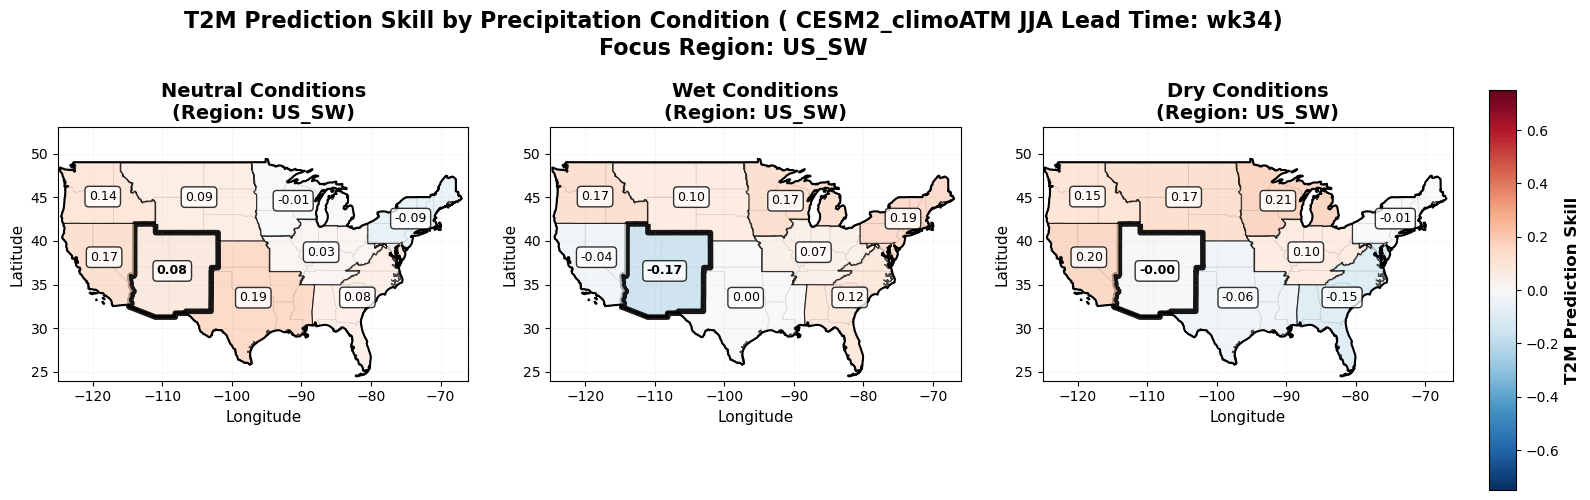

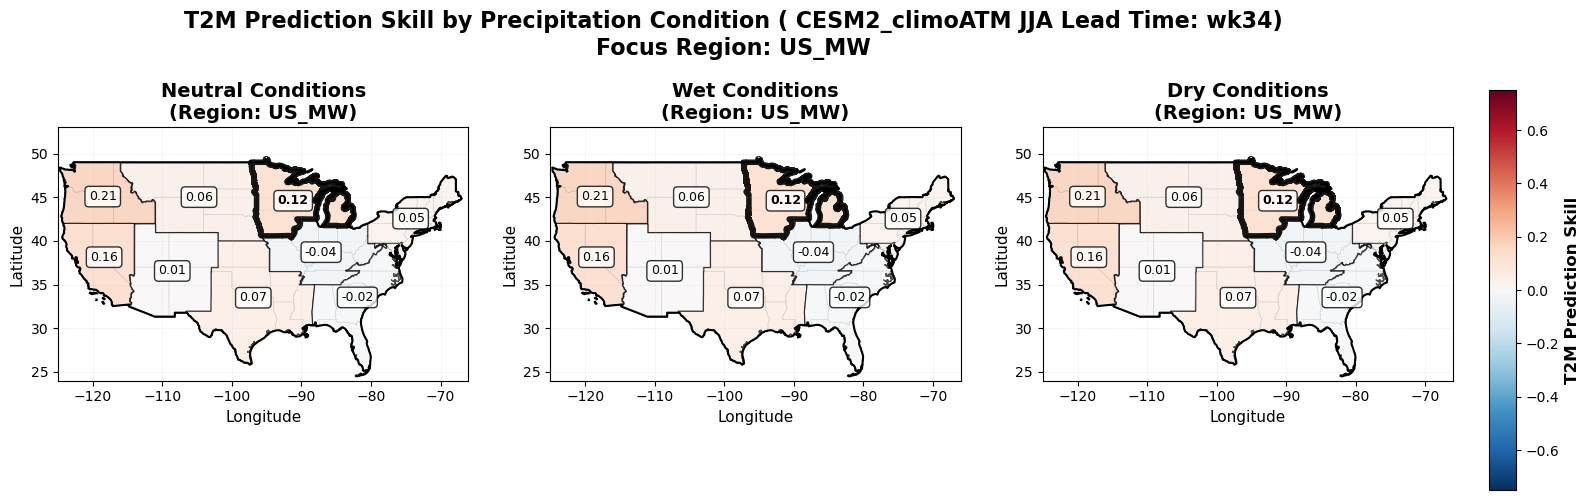

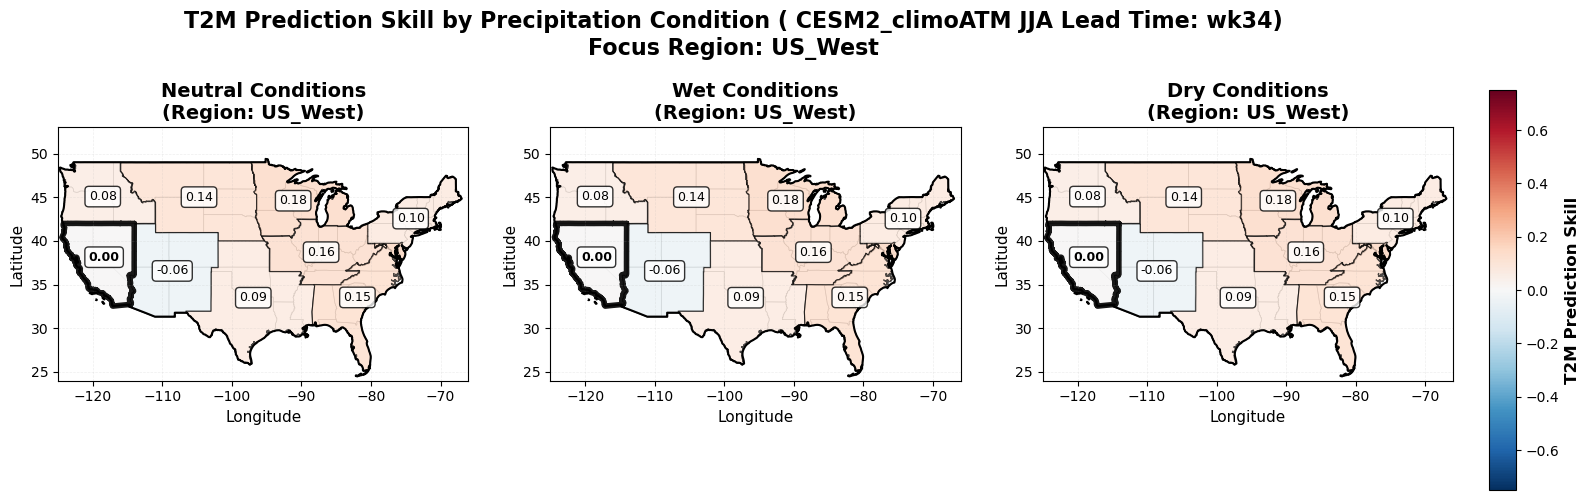

In [66]:
### Option 2: Single region, single lead time

for iReg in range(len(heat_array.regions.values)):
    fig, axes = create_skill_maps_for_region(
        region_idx=iReg,
        heatmap_all=heat_array,
        shapefiles=shapefiles,
        shapefile_dir=shapefile_dir,
        region_names=heat_array.regions.values,
        lead_time=1
    )
